In [1]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [2]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2
import sqlite3, thread, urllib, dateparser
from datetime import timedelta

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [3]:
exec_ipynb('colormaps.ipynb')

In [4]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [5]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in 2018 US House boundaries

In [11]:
ush_2018 = gpd.read_file('voting/Remedial Plan Shapefile.shp').to_crs(epsg=4326)

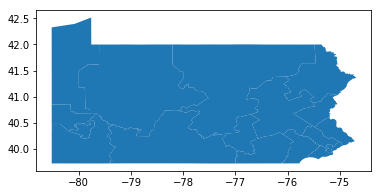

In [12]:
ush_2018.plot()

In [ ]:
ush_2018

In [14]:
# Create a GeoDataFrame that just has DISTRICT and geometry
ush_out_2018 = gpd.GeoDataFrame(ush_2018[['DISTRICT']], geometry=ush_2018.geometry,crs={'init': 'epsg:4326'})

In [ ]:
ush_out_2018

In [16]:
# Write out the 2018 US House geometry as a geojson file
ush_out_2018.to_file('voting/pa_us_house_boundaries_2018.geojson', driver="GeoJSON")

In [17]:
binarize_geojson_outlines('voting/pa_us_house_boundaries_2018.geojson', 
                          'voting/pa_us_house_boundaries_2018.bin')

Read 18 features from voting/pa_us_house_boundaries_2018.geojson
112242 segments
Created voting/pa_us_house_boundaries_2018.bin (112242 segments)


# Read in 2018 PA House boundaries

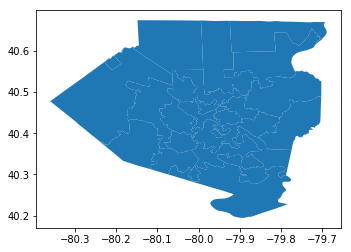

In [456]:
pah_2018 = gpd.read_file('voting/Allegheny_County_Pennsylvania_House_of_Representatives_District_Boundaries.shp').to_crs(epsg=4326)
pah_2018.plot()

In [ ]:
pah_2018

In [458]:
# Write out the 2018 PA House geometry as a geojson file
pah_2018.to_file('voting/ac_pa_house_boundaries_2018.geojson', driver="GeoJSON"
binarize_geojson_outlines('voting/ac_pa_house_boundaries_2018.geojson', 
                          'voting/ac_pa_house_boundaries_2018.bin')

Read 23 features from voting/ac_pa_house_boundaries_2018.geojson
24593 segments
Created voting/ac_pa_house_boundaries_2018.bin (24593 segments)


# Read in 2018 PA Senate boundaries

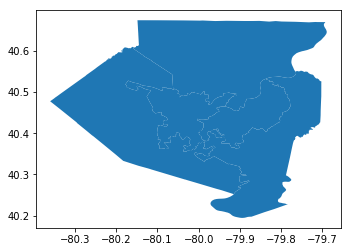

In [459]:
pas_2018 = gpd.read_file('voting/Allegheny_County_Pennsylvania_Senate_District_Boundaries.shp').to_crs(epsg=4326)
pas_2018.plot()

In [ ]:
pas_2018

In [461]:
# Write out the 2018 PA Senate geometry as a geojson file
pas_2018.to_file('voting/ac_pa_senate_boundaries_2018.geojson', driver="GeoJSON")

binarize_geojson_outlines('voting/ac_pa_senate_boundaries_2018.geojson', 
                          'voting/ac_pa_senate_boundaries_2018.bin')

Read 5 features from voting/ac_pa_senate_boundaries_2018.geojson
8906 segments
Created voting/ac_pa_senate_boundaries_2018.bin (8906 segments)


# Polling places

In [116]:
# Get old polling place locations
pp_2017 = gpd.read_file('voting/Polling_Place_Locations_May_2017.shp').to_crs(epsg=4326)

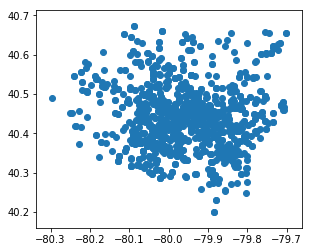

In [41]:
pp_2017.plot()

In [ ]:
pp_2017

In [ ]:
pp_2017[pp_2017.MWD2.duplicated()]

In [ ]:
pp_2017[pp_2017.MWD2==1881926]

In [119]:
# Get rid of Brookline terrace based on discussion with David Hoyt
# on 10/25/18
pp_2017 = pp_2017[~(pp_2017.MWD2.duplicated())]

In [124]:
# Get intermediate polling place locations
pp_2018_05 = gpd.read_file('voting/PollingPlaces2018_May.shp').to_crs(epsg=4326)


In [ ]:
pp_2018_05[pp_2018_05.MWD2.duplicated()]

In [125]:
pp_2018_05 = pp_2018_05[~pp_2018_05.MWD2.duplicated()]

In [409]:
# Get new polling place locations
pp_2018_11 = gpd.read_file('voting/Allegheny_County_Polling_Place_Locations_November_2018.shp').to_crs(epsg=4326)


In [410]:
pp_2018_11[pp_2018_11.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.818078,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.818078,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [411]:
pp_2018_11 = pp_2018_11[~pp_2018_11.MWD2.duplicated()]

In [129]:
pp_2018_m = pd.merge(pp_2018_11,pp_2018_05[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_11', '_18_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [130]:
pp_2018_2017_m = pd.merge(pp_2018_m,pp_2017[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_m', '_17_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [135]:
# Rename NewAddress to NewAddress_17_05
pp_2018_2017_m=pp_2018_2017_m.rename(columns={'NewAddress':'NewAddress_17_05'})

In [132]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1881926]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress
618,296,296.0,188,19,26,TREE OF LIFE CHURCH,None,1036,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097H00001000000,None,12,7,1.337211e+06,393627.765169,14.0,42.0,22.0,None,PITTSBURGH,1036 BROOKLINE BLVD,1881926,1.337211e+06,393627.765169,1881926,1036 BROOKLINE BLVD,POINT (-80.01663330913114 40.39164418362884),1036 BROOKLINE BLVD,1036 BROOKLINE BLVD


In [138]:
# Changed since 2017_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05])

59

In [141]:
pp_2018_2017_m['addr_changed_17'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05

In [139]:
# Changed since 2018_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05])

31

In [142]:
pp_2018_2017_m['addr_changed_18'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05

In [ ]:
pp_2018_2017_m[pp_2018_2017_m.addr_changed_18].sort_values(['MuniName','MWD2'])[['MuniName','MWD2','LocName','NewAddress_18_11','NewAddress_18_05','addr_changed_17','addr_changed_18','geometry']]

In [148]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1660201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
961,MCCANDLESS,1660201,10375 PERRY HWY,10375 PERRY HWY,False,False,POINT (-80.05354114992568 40.60391226742988)


In [149]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==2280201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
858,WILKINSBURG,2280201,1256 FRANKLIN AVE,1256 FRANKLIN AVE,False,False,POINT (-79.87451573119165 40.43750237177388)


In [156]:
len(pp_2018_2017_m[(pp_2018_2017_m['addr_changed_17']) & ~(pp_2018_2017_m['addr_changed_18'])])

29

In [152]:
# This was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-AW3b-Polling.ipynb, 
# then modified to deal with addition of 18_05 data
def write_pp_csv(df, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write(",lat,lon,%s\n" % (",".join(map(str,date_range))))
    
    i=0
    for i in range(0,len(df)):
        coords = df['geometry'].iloc[i]
        lon = coords.x
        lat = coords.y
        mwd = df['MWD2'].iloc[i]
        
        # Write size row
        out_data=[mwd, lat, lon]
        for year in date_range:
            out_val = 20
            out_data.append(out_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
        
        # Write color row: Color =1 for changed in 2018, .5 for changed in 2017, 0 for stable
        out_data=[mwd, lat, lon]
        color_val = 0
        if df['addr_changed_18'].iloc[i]:
            color_val=1
        elif df['addr_changed_17'].iloc[i]:
            color_val = 0.5
        
        for year in date_range:
            out_data.append(color_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [153]:
write_pp_csv(pp_2018_2017_m, "voting/pa_ac_polling_places_2018b.csv")

# Deal with voting file from county

# Address mapping

In [6]:
# Key is string canonical address, value is a map: {'canonical_in_census_db': True/False,'canonical_in_google_db': True/False, 'other_addr_strings':Set, 'census_value':str, 'google_value':str
canonical_addr_map={}

In [7]:
def canonicalize_string(text):
    # Remove any leading or trailing whitespace, replace any internal whitespace with single spaces, upcase it all
    ret = re.sub("^\s+|\s+$", "", text)
    ret = re.sub("\s+", " ", ret)
    return ret.upper()

In [8]:
# Try to load canonical_addr_map originally created by 
#  http://localhost:8820/notebooks/projects/demographics/Fixup%20Address%20DB.ipynb
# 'assessments/canonical_addr_map_e.pickle' has census_block addresses resolutions for 2005-02 and 2013-02
import pickle
pickle_file_path = 'assessments/canonical_addr_map_e.pickle'

In [9]:
# Load in canonical_addr_map
with open(pickle_file_path, 'rb') as handle:
    canonical_addr_map = pickle.load(handle)

In [440]:
# Save out canonical_addr_map
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(canonical_addr_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
len(canonical_addr_map)

3057385

In [11]:
# From http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb

# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow
import dateparser

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [12]:
# Google addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
from shapely.geometry import Point
import collections


# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    result=None
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['google_value']):
        result = json.loads(canonical_addr_map[caddr]['google_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or google address lookup service
        try:
            geocode_address_google.conn
        except:
            geocode_address_google.conn = sqlite3.connect('geocoding_cache')
            geocode_address_google.cur = geocode_address_google.conn.cursor()
            geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                         ' (key PRIMARY KEY, value)'
                                         ' WITHOUT ROWID;'))
            geocode_address_google.conn.commit()

        geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = geocode_address_google.cur.fetchall()
        if rows:
            #print "Google: Found %r in cache" % (caddr)
            gval = rows[0][0]
            result = json.loads(gval)
        else:
            # Not in sqlite, ask google address service
            #print "Google: %r not found in cache, fetching" % (address)

            api_key = open('google-api-key-do-not-commit.txt').read()
            payload = {'address':caddr, 'key':api_key}
            result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
            # Keep the stringified version for the DB/canonical_addr_map
            gval = json.dumps(result)
            geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                         ' VALUES (?, ?);'),
                                         (caddr, gval))
            geocode_address_google.conn.commit()
            
            # If the result succeeded and generated a formatted address, cache under that key too
            try:
                if(result['status']=='OK'):
                    if(len(result['results'])== 1):
                        canonical = result['results'][0]['formatted_address']
                        #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                        geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                             ' VALUES (?, ?);'),
                                                             (canonical, gval))
                        geocode_address_google.conn.commit()
                    else:
                        print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

                else:
                    print "Google: Fetch %r failed" % (address)
                
            except:
                #pass
                raise
                
        # We had to resort to sqlite/google address service.  Add gval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':False,'canonical_in_google_db': True, 
                                       'census_value':None, 'google_value':gval}
        else:
            # Already there, presumably for census.  Add google value 
            canonical_addr_map[caddr]['canonical_in_google_db']=True
            canonical_addr_map[caddr]['google_value']=gval
 
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None
    
def get_canonical_coords_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            latlon = result['results'][0]['geometry']['location']
            if(latlon):
                return(Point(latlon['lng'], latlon['lat']))
        return None
    except Exception as e:
        print "Exception processing get_canonical_coords_google(%s): %s" % (addr, e)
        return None


In [13]:
# Census addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#

# Uses Census geocoding API to geocode an address

import sqlite3
import urllib,urllib2
import json
from shapely.geometry import Point
import collections

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['census_value']):
        result = json.loads(canonical_addr_map[caddr]['census_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or census address lookup service
        try:
            geocode_address_census.sqlite
        except:
            geocode_address_census.sqlite = {}

        tpid = '%d.%s' % (os.getpid(), thread.get_ident())
        if not tpid in geocode_address_census.sqlite:
            conn = sqlite3.connect('geocoding_cache_census')
            cur = conn.cursor()
            geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

            cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                         ' (key PRIMARY KEY, value)'
                         ' WITHOUT ROWID;'))
            conn.commit()
        else:
            conn = geocode_address_census.sqlite[tpid]['conn']
            cur = geocode_address_census.sqlite[tpid]['cur']

        cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = cur.fetchall()
        if rows:
            cval = rows[0][0]
        else:
            payload = {'address':caddr, 'benchmark':4, 'format':'json'}
            result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
            cval = json.dumps(result)

            cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                         ' VALUES (?, ?);'),
                        (caddr, cval))
            conn.commit()

            if len(result['result']['addressMatches']) == 1:
                canonical = result['result']['addressMatches'][0]['matchedAddress']
                cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                             ' VALUES (?, ?);'),
                             (canonical, cval))
                conn.commit()
            
        # We had to resort to sqlite/google address service.  Add cval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':True,'canonical_in_google_db': False, 
                                       'census_value':cval, 'google_value':None}
        else:
            # Already there, presumably for google.  Add census value 
            canonical_addr_map[caddr]['canonical_in_census_db']=True
            canonical_addr_map[caddr]['census_value']=cval

    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address_census(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

    
def get_canonical_coords_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            coords = result['result']['addressMatches'][0]['coordinates']
            return(Point(coords['x'], coords['y']))
        else:
            return None
    except:
        return None

################################################################################################################
# These can handle being passed a map with either census or google in it and dispatch to the right service

# TODO: Think if this is the right behavior: If handed a regular string do census lookup
# If handed a map, return census if non-null, then google if non-null
def get_canonical_address(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return addr['census']
        elif('google' in addr and not pd.isnull(addr['google'])):
            return addr['google']
    else:
        return(get_canonical_address_census(addr))

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_zip_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_zip_google(addr['google'])
    else:
        return(get_canonical_zip_census(addr))

def get_canonical_coords(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_coords_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_coords_google(addr['google'])
    else:
        return(get_canonical_coords_census(addr))

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address_census(' '.join(x)), axis=1)
    
    

In [14]:
# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: canonicalize_string(' '.join(x)), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)


# Deal with various versions of the voter DB

In [15]:
voters_addr_cols=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City', 'State','Zip_Code']
voters_dtype={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 'StreetNameComplete':numpy.str ,'City':numpy.str, 
              'State':numpy.str,'Zip_Code':numpy.str,'Dist1':numpy.str}

# 2009-07 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str
                  }

# 2005-02 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files%202005-02.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str,'Vote_History':numpy.str
                  }

voters_info = {
    '2018-10': {'path': 'voters/2018-10-cd/10_16_18VOTERS.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-08': {'path': 'voters/2018-08-cd/VOTERS8_14_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-03': {'path': 'voters/2018-03-cd/VOTERS3_5_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2017-11': {'path': 'voters/2017-11-cd/VOTERS11_30_2017.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2013-02': {'path': 'voters/2013-02-cd/VOTERS_VH_2013-02-19.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2009-07': {'path': "voters/2009-07-cd/VOTERS07_22_2009.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               },
    '2005-02': {'path': "voters/2005-02-cd/VOTERS02_07_2005.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               }

}

In [16]:
monthstr_to_date_map={'2005-02':dateparser.parse("2/7/2005"),
                      '2005-08':dateparser.parse("8/5/2005"),
                      '2009-07':dateparser.parse("7/22/2009"),
                      '2013-02':dateparser.parse("2/19/2013"),
                      '2013-04':dateparser.parse("4/29/2013"),
                      '2014-06':dateparser.parse("6/18/2014"),
                      '2015-09':dateparser.parse("9/11/2015"),
                      '2016-09':dateparser.parse("9/2/2016"),
                      '2017-04':dateparser.parse("4/21/2017"),
                      '2017-10':dateparser.parse("10/16/2017"),
                      '2017-11':dateparser.parse("11/30/2017"),
                      '2018-06':dateparser.parse("6/12/2018"),
                      '2018-03':dateparser.parse("3/5/2018"),
                      '2018-08':dateparser.parse("8/14/2018"), 
                      '2018-10':dateparser.parse("10/16/2018")
                     }

In [17]:
# Hold on to the dataframes associated with each month_str in a map
vdf_map={}

In [18]:
# Do fixup on Pitt addresses
def fixup_pitt_addresses(df):
    df['address_raw'] = df['address_raw'].str.replace('(^.*((PITT TOWERS)|(5TH AVE-MCCORMICK HALL)|(HOLLAND HALL)) PITTSBURGH PA 15213$)', '3990 FIFTH AVE PITTSBURGH PA 15213', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*AMOS HALL PITTSBURGH PA 15213$)', '3959 FIFTH AVE PITTSBURGH PA 15260', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*SUTHERLAND HALL PITTSBURGH PA 15213$)', '3725 SUTHERLAND DR PITTSBURGH PA 15213', regex=True)
    
    

In [19]:
def load_voters_info(month_str):
    if(not month_str in voters_info):
        print "No entry for %s in voters_info" % (month_str)
    path = voters_info[month_str]['path']
    vdf_map[month_str] = pandas.read_csv(path,sep='\t',dtype=voters_info[month_str]['dtype']).set_index('ID_Number')
    merge_addr_colset(vdf_map[month_str], voters_info[month_str]['addr_cols'], 'address_raw')
    fixup_pitt_addresses(vdf_map[month_str])
    return vdf_map[month_str]

In [18]:
# Key is voter ID, DOB:str, reg_date:str, 
#    reg_info:{month_str: {status: , party: }}, addresses:{month_str:address}}
#    vote_info:{vote_str: {party: , 'how': }}
# vote_str is in the form GN_11_06_12 or PR_05_15_18 or PR_05_17_11
# In the case of vote_info records added from fixed width files,
#    'party' is set to be earliest known party and 'how' is None
# In the case of those added from later files, 'how' is processed directly:
#    'AP' indicates the voter cast their ballot at the polls
#    'AB' indicates the voter cast an absentee ballot
#    'P' indicates that the voter cast a provisional ballot
# Added by voter_process_address_history:
#   'addr_arr':[{'address': , 'date': , 'census_block': , 'latlon': },]
voter_map = {}

In [20]:
# Key is vote_str, value is {'date': datetime, 'month_strs': set(month_str),'date_type': }
# 'date_type' is 'exact' if we actually knew the date, or 'approx' if we're just guessing
# strings generated from fixed width files will be created as 'approx' dates; those
# created by newer files will be 'exact'.  
vote_map = {}
# vote_arr is an ordered list of tuples in time order [(vs1, date1), (vs2, date2)...]
# The invariant is that when an item is added to vote_map, vote_arr must be regenerated
# appropriately
vote_arr = []

In [21]:
# This is an array mapping from the index of Vote_History strings into 
# vote_str strings.  Earlier than the first exact date strings these are just 
# PR_YYYY and GN_YYYY.  After the first exact date strings, these are PR_MM_DD_YY
vote_history_index_to_vote_str=[]

In [22]:
# Any time vote_map is changed in a way that affects dates this should be called
# so we always have a sorted list of votes
def regenerate_vote_arr():
    global vote_arr
    global vote_map
    vote_arr = sorted(vote_map.items(),key=lambda x:x[1]['date'])

# Vote strings are in the form TT_MM_DD_YY, parse the date
def vote_str_to_date(vote_str):
    str_date = datetime.datetime.strptime(vote_str[3:], '%m_%d_%y')
    return(str_date)

# Given a list of column names return a list of vote_str values included in the dataframe
# and populate vote_map with the date if we don't already have it
def columns_to_vote_strs(month_str, column_list):
    global vote_arr
    global vote_map

    # Process any new style column names
    vote_str_list = list(filter(lambda x: ('GN_' in x or 'PR_' in x or 'SP_' in x) and (not '_VM' in x), 
                                column_list))
    
    for vote_str in vote_str_list:
        if not vote_str in vote_map:
            vote_map[vote_str] = {'date': vote_str_to_date(vote_str), 
                                  'month_strs': set([month_str]), 
                                  'date_type':'exact'
                                 }
        else:
            vote_map[vote_str]['month_strs'].add(month_str)
            
    regenerate_vote_arr()
    return(vote_str_list)

# Old style Vote_History from fixed width files start with the primary of 1983 but only have
# 2 bits of info about each election: '0' = not registered, '1' = voted, '2' = didn't vote
# we don't know exact dates or party affiliation.

# Add entries into vote_map for the longest of these, which is currently 2009.
# Before calling this, dadd '2013-02', or whatever the oldest of the new style 
# files are, so vote_map contains exact entries for the earliest dates it can

# See the file VoterThankYou-12Dec2007 in https://drive.google.com/drive/folders/1xVsl029scwhnVnXa-v6XpFufjOavNrhe
# for definitions on the format of the Vote_History string
def add_vote_history_map_entries():
    first_new_style_year = 2004
    last_new_style_year = 2010
    history_month_str = '2005-02'
    new_style_names = list(filter(lambda x: ('GN_' in x or 'PR_' in x),vote_map.keys()))
    
    idx = 0
    for year in range(1983, last_new_style_year):
        pr_name = "PR_%4d"%(year)
        gn_name = "GN_%4d"%(year)
        # Estimate priaries as 5/16/YYYY and general elections as 11/6/YYYY if we don't know 
        # any better
        pr_date = dateparser.parse("5/16/%d"%(year))
        gn_date = dateparser.parse("11/6/%d"%(year))
        pr_type = 'approx'
        gn_type = 'approx'
        if(year>=first_new_style_year):
            # Try to retrieve the exact dates from vote_map
            yy = ("%d"%(year))[2:4]
            pr_names = list(filter(lambda x: bool(re.search('PR_\d\d_\d\d_%s'%(yy), x)), 
                                 new_style_names))
            gn_names = list(filter(lambda x: bool(re.search('GN_\d\d_\d\d_%s'%(yy), x)), 
                                 new_style_names))
            #print "%d: Search for %s: pr=%r, gn=%r" % (idx, yy, pr_names, gn_names)
            if(len(pr_names)==1):
                pr_name = pr_names[0]
                pr_date = vote_map[pr_name]['date']
                pr_type = vote_map[pr_name]['date_type']
            if(len(gn_names)==1):
                gn_name = gn_names[0]
                gn_date = vote_map[gn_name]['date']
                gn_type = vote_map[gn_name]['date_type']
        # Do PR then GN for this year and increment index 
        vote_history_index_to_vote_str.append(pr_name)
        vote_history_index_to_vote_str.append(gn_name)
        idx = idx+2
        
        # Add to vote_map
        if not pr_name in vote_map:
            vote_map[pr_name] = {'date': pr_date, 
                                  'month_strs': set([history_month_str]), 
                                  'date_type':pr_type
                                 }
        else:
            vote_map[pr_name]['month_strs'].add(history_month_str)
            
        if not gn_name in vote_map:
            vote_map[gn_name] = {'date': gn_date, 
                                  'month_strs': set([history_month_str]), 
                                  'date_type':gn_type
                                 }
        else:
            vote_map[gn_name]['month_strs'].add(history_month_str)
            
    # Udpdate vote_arr to make sure new entries are in there and in order
    regenerate_vote_arr()


#####################################################
# Individual voter vote_info support
# Given the existing vote_info_map for a voter, add an entry for 
# a given vote_str, party, and how.  
def add_vote_record(vote_info_map, vote_str, party, how):
    if vote_str in vote_info_map:
        # There's already an entry.  Is this new info better?
        if(how and not vote_info_map[vote_str]['how']):
            # This new info is better, use it
            vote_info_map[vote_str]['how']=how
            vote_info_map[vote_str]['party']=party
        else:
            # This is a duplicate, ignore it
            pass
    else:
        # There's not an entry yet, create one
        vote_info_map[vote_str]={'party': party, 'how':how}
        

# Find all the '1's in the history str, translate those into 
def process_vote_history(vote_info_map, history_str, party):
    idx=0
    while(idx != -1 and idx < len(history_str)):
        # Find the index of the next '1'
        new_idx = history_str.find('1', idx)
        #print "Found %d (%d)"% (new_idx,idx)
        if(new_idx!=-1):
            # Found a vote that this voter participated in
            vote_str = vote_history_index_to_vote_str[new_idx] if new_idx < len(vote_history_index_to_vote_str) else None
            if(vote_str):
                add_vote_record(vote_info_map, vote_str, party, None)
            else:
                print "WARNING: No entry in vote_history_index_to_vote_str for index %d"% (new_idx)
                break
            idx=new_idx+1
        else:
            break

    return(vote_info_map)
                
def process_vote_columns(vote_info_map, df, i):
    vote_strs = columns_to_vote_strs(month_str, list(df))
    for vote_str in vote_strs:
        if not pd.isna(df[vote_str].iloc[i]):
            # They voted in this one, find out how
            party = df[vote_str].iloc[i]
            how = df["%s_VM"%(vote_str)].iloc[i]
            add_vote_record(vote_info_map, vote_str, party, how)

    return(vote_info_map)

def get_next_vote_str_rec_after_date(vote_info_map, cmp_date):
    if(not cmp_date):
        return None
    
    # Find and return the next item after this one in vote_arr or None if we're past the end 
    return (next((item for item in vote_arr if item[0] in vote_info_map and item[1]["date"] > cmp_date),None))

def get_vote_str_rec_on_or_after_date(vote_info_map, cmp_date):
    # Find and return the next item after this one in vote_arr or None if we're past the end 
    return (next((item for item in vote_arr if item[0] in vote_info_map and item[1]["date"] >= cmp_date),None))

In [23]:
# Keep track of what month_strs are in the current voter_map
active_month_str_set=set(['2005-02', '2009-07', '2013-02', '2017-11', '2018-03', '2018-08', '2018-10'])
active_month_str_arr=sorted(list(active_month_str_set))

In [24]:
# Check we have everything
for month_str in (active_month_str_arr):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2005-02: ['path', 'addr_cols', 'dtype']
2009-07: ['path', 'addr_cols', 'dtype']
2013-02: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-10: ['path', 'addr_cols', 'dtype']


In [25]:
# Keep track of the Municipality/Ward/District seen for each address
# Key is address, value is a map from month_str to MWD value seen in that data set
addr_to_mwd_map = {}

In [26]:
def process_voting_record(apd, i, month_str):
    global voter_map

    # Generate set of interesting colnames we have in this data frame
    interesting_colnames=set(['address_raw','Voter_Status','Political_Party','Last_Date_Voted','Date_Last_Changed','Date_Of_Birth','Date_Registered','Dist1','Vote_History'])
    colnames = set(apd.columns) & interesting_colnames

    voter_id = apd.iloc[i].name
        
    if(not voter_id in voter_map):
        # Make sure 'Date_Registered' is legit
        reg_date = None
        try:
            if(apd['Date_Registered'].iloc[i]!='nan'):
                reg_date = dateparser.parse(apd['Date_Registered'].iloc[i])
        except:
            reg_date = None

        if(not reg_date):
            print "Skipping %s, unparsable registration date %s" % (voter_id, apd['Date_Registered'].iloc[i])
            return

        # reg_date is fine, add an entry
        voter_map[voter_id]={'DOB':apd['Date_Of_Birth'].iloc[i], 'reg_date':reg_date, 'reg_info':{}, 'addresses':{}}
    
    this_addr = apd['address_raw'].iloc[i]
    party = apd['Political_Party'].iloc[i]
    voter_map[voter_id]['reg_info'][month_str] = {'status':apd['Voter_Status'].iloc[i],'party':party}
    voter_map[voter_id]['addresses'][month_str] = this_addr
    
    # If Dist1 is set, update addr_to_mwd_map
    if('Dist1' in apd.columns):
        mwd = apd['Dist1'].iloc[i]
        if(not this_addr in addr_to_mwd_map):
            # New address, create entry
            addr_to_mwd_map[this_addr]={}
        addr_to_mwd_map[this_addr][month_str]=mwd
        
    # Deal with voting history
    if(not 'vote_info' in voter_map[voter_id]):
        voter_map[voter_id]['vote_info']={}
        
    if('Vote_History' in colnames):
        # This is one of the older files, process voter records
        process_vote_history(voter_map[voter_id]['vote_info'], apd['Vote_History'].iloc[i], party)
    else:
        # This is a newer file, process columns
        process_vote_columns(voter_map[voter_id]['vote_info'], apd, i)
    
def process_all_voting_records(apd,month_str):
    active_month_str_set.add(month_str)
    active_month_str_arr=sorted(list(active_month_str_set))
    for i in range(0,len(apd)):
        process_voting_record(apd, i, month_str)

In [27]:
active_month_str_arr=sorted(list(active_month_str_set))
active_month_str_arr

['2005-02', '2009-07', '2013-02', '2017-11', '2018-03', '2018-08', '2018-10']

In [28]:
vdf_2018_10 = load_voters_info('2018-10')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [16]:
vdf_2018_08 = load_voters_info('2018-08')

In [172]:
vdf_2018_03 = load_voters_info('2018-03')

In [23]:
vdf_2017_11 = load_voters_info('2017-11')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [29]:
vdf_2013_02 = load_voters_info('2013-02')

In [444]:
vdf_2009_07 = load_voters_info('2009-07')

In [30]:
vdf_2005_02 = load_voters_info('2005-02')

### Deal with Date_Last_Changed

In [ ]:
vdf_2005_02['DOB']=vdf_2005_02['Date_Of_Birth'].map(dateparser.parse)
vdf_2005_02['DR']=vdf_2005_02['Date_Registered'].map(dateparser.parse)
vdf_2005_02['DLC']=vdf_2005_02['Date_Last_Changed'].map(dateparser.parse)
vdf_2005_02['suspect_dates']=~((vdf_2005_02['DOB']<vdf_2005_02['DR']) & (vdf_2005_02['DR']<=vdf_2005_02['DLC']) & (vdf_2005_02['DLC']<=monthstr_to_date_map['2005-02']))

vdf_2005_02[vdf_2005_02['suspect_dates']][['DOB','DR','DLC','address_raw']]

In [ ]:
vdf_2009_07['DOB']=vdf_2009_07['Date_Of_Birth'].map(dateparser.parse)
vdf_2009_07['DR']=vdf_2009_07['Date_Registered'].map(dateparser.parse)
vdf_2009_07['DLC']=vdf_2009_07['Date_Last_Changed'].map(dateparser.parse)
vdf_2009_07['suspect_dates'] = ~((vdf_2009_07['DOB']<vdf_2009_07['DR']) & (vdf_2009_07['DR']<=vdf_2009_07['DLC']) & (vdf_2009_07['DLC']<=monthstr_to_date_map['2009-07']))

vdf_2009_07[vdf_2009_07['suspect_dates']][['DOB','DR','DLC','address_raw']]

In [39]:
%%time
vdf_2009_07['DOB']=pd.to_datetime(vdf_2009_07['Date_Of_Birth'])

NameError: name 'vdf_2009_07' is not defined

In [ ]:
vdf_2009_07['DR']=vdf_2009_07['Date_Registered'].map(dateparser.parse)
vdf_2009_07['DLC']=vdf_2009_07['Date_Last_Changed'].map(dateparser.parse)
vdf_2009_07['suspect_dates'] = ~((vdf_2009_07['DOB']<vdf_2009_07['DR']) & (vdf_2009_07['DR']<=vdf_2009_07['DLC']) & (vdf_2009_07['DLC']<=monthstr_to_date_map['2009-07']))

vdf_2009_07[vdf_2009_07['suspect_dates']][['DOB','DR','DLC','address_raw']]

In [38]:
# Combine 2005_02 and 2009_07
vdf_2005_02_jr = vdf_2005_02[['DOB','DR','DLC','suspect_dates','address_raw']].rename(columns={'DOB':'DOB_2005-02', 'DR':'DR_2005-02', 'DLC':'DLC_2005-02','suspect_dates':'suspect_dates_2005-02','address_raw':'address_raw_2005-02'})
vdf_2009_07_jr = vdf_2009_07[['DOB','DR','DLC','suspect_dates','address_raw']].rename(columns={'DOB':'DOB_2009-07', 'DR':'DR_2009-07', 'DLC':'DLC_2009-07','suspect_dates':'suspect_dates_2009-07','address_raw':'address_raw_2009-07'})
v97_25_j = vdf_2005_02_jr.join(vdf_2009_07_jr,how='outer')

KeyError: "['DOB' 'DR' 'DLC' 'suspect_dates'] not in index"

In [ ]:
v97_25_both=(~pd.isna(v97_25_j['DOB_2005-02']))&(~pd.isna(v97_25_j['DOB_2009-07']))
v97_25_j[v97_25_both & (v97_25_j['address_raw_2005-02']!=v97_25_j['address_raw_2009-07'])]

In [496]:
v25_only=(~pd.isna(v97_25_j['DOB_2005-02']))&(pd.isna(v97_25_j['DOB_2009-07']))
v97_25_j[v25_only]

,DOB_2005-02,DR_2005-02,DLC_2005-02,suspect_dates_2005-02,address_raw_2005-02,DOB_2009-07,DR_2009-07,DLC_2009-07,suspect_dates_2009-07,address_raw_2009-07
ID_Number,,,,,,,,,,
001023473-02,1970-01-11,2004-01-01,2004-10-12,False,3111 SQUIRES MANOR LN SOUTH PARK PA 15129,NaT,NaT,NaT,NaN,NaN
001024003-02,1977-02-10,2004-01-01,2004-10-05,False,1927 MURRAY AVE PITTSBURGH PA 15217,NaT,NaT,NaT,NaN,NaN
001024171-02,1953-09-04,1996-10-01,2004-04-07,False,106 LINDEN AVE S PITTSBURGH PA 15208,NaT,NaT,NaT,NaN,NaN
001024313-02,1975-01-21,2009-07-01,2005-01-05,True,214 ONEIDA ST PITTSBURGH PA 15211,NaT,NaT,NaT,NaN,NaN
001025031-02,1972-11-20,2004-01-01,2004-10-16,False,63 NINETEENTH ST S PITTSBURGH PA 15203,NaT,NaT,NaT,NaN,NaN
001025191-02,1979-05-08,2004-01-01,2004-08-06,False,5701 CENTRE AVE PITTSBURGH PA 15206,NaT,NaT,NaT,NaN,NaN
001027557-02,1978-11-08,1997-04-01,2004-10-14,False,601 MINNESOTA ST PITTSBURGH PA 15207,NaT,NaT,NaT,NaN,NaN
001029025-02,1977-07-19,1997-07-01,2004-10-05,False,5850 CENTRE AVE PITTSBURGH PA 15206,NaT,NaT,NaT,NaN,NaN


In [525]:
test_vid = '001015655-02'
v97_25_j[v97_25_j.index==test_vid]

,DOB_2005-02,DR_2005-02,DLC_2005-02,suspect_dates_2005-02,address_raw_2005-02,DOB_2009-07,DR_2009-07,DLC_2009-07,suspect_dates_2009-07,address_raw_2009-07
ID_Number,,,,,,,,,,
001015655-02,1943-01-22,1972-01-01,2003-10-14,False,203 HUGEL DR PITTSBURGH PA 15209,1943-01-22,1972-01-01,2003-10-14,False,203 HUGEL DR PITTSBURGH PA 15209


In [531]:
voter_map[test_vid]

{'DOB': '1/22/1943',
 'addr_arr': [{'address': '203 HUGEL DR PITTSBURGH PA 15209',
   'census_block': u'420034272003017',
   'date': datetime.datetime(1972, 1, 1, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f46e06d2590>}],
 'addresses': {'2005-02': '203 HUGEL DR PITTSBURGH PA 15209',
  '2009-07': '203 HUGEL DR PITTSBURGH PA 15209',
  '2013-02': '203 HUGEL DR PITTSBURGH PA 15209',
  '2017-11': '203 HUGEL DR PITTSBURGH PA 15209',
  '2018-03': '203 HUGEL DR PITTSBURGH PA 15209'},
 'last_update_date': {'2005-02': Timestamp('2003-10-14 00:00:00'),
  '2009-07': Timestamp('2003-10-14 00:00:00')},
 'reg_date': datetime.datetime(1972, 1, 1, 0, 0),
 'reg_info': {'2005-02': {'party': 'D', 'status': 'A'},
  '2009-07': {'party': 'D', 'status': 'A'},
  '2013-02': {'party': 'D', 'status': 'A'},
  '2017-11': {'party': 'D', 'status': 'A'},
  '2018-03': {'party': 'D', 'status': 'A'}},
 'vote_info': {'GN_11_02_04': {'how': 'AP', 'party': 'D'},
  'GN_11_02_10': {'how': 'AP', 'party': 'D'},
  '

In [500]:
updated_vids = set()

In [527]:
# Given a dataframe with DOB_ms, DR_ms, DLC_ms, suspect_dates_ms, and address_raw_ms for each ms in month_strs, 
# Fixup the addresses 
def fixup_addr_dates(df, month_strs, force):
    # Hold on to sorted list of months that we're going to process
    msms_arr = sorted(month_strs)
    # Setup a map from [topic][month_str]->colname
    colmap={}
    for topic in ['DOB','DR','DLC','suspect_dates','address_raw']:
        colmap[topic]={}
        for month_str in month_strs:
            colmap[topic][month_str]="%s_%s"%(topic,month_str)
            
    for i in range(0,len(df)):
        vid = df.iloc[i].name
        if not vid in voter_map:
            continue
        vrec = voter_map[vid]
        
        # Hold on to sorted list of months already processed into this entry for voter_map
        ex_ms_arr= sorted(vrec['reg_info'].keys())
        
        for m_i in range(0,len(msms_arr)):
            month_str=msms_arr[m_i]
            # Check if we have an address for this voter for this month_str
            this_addr = df[colmap['address_raw'][month_str]].iloc[i]
            if pd.isna(this_addr):
                # Nope, skip this one
                continue
            # We have an address for this month_str for this voter, when did it take effect?
            dr = df[colmap['DR'][month_str]].iloc[i]
            dlc= df[colmap['DLC'][month_str]].iloc[i]
            last_update_date = max(dr,dlc)
            
            # Double check that stored dr and he new dr match
            if dr != vrec['reg_date']:
                print "WARNING: %s: reg_date mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,dr,vrec['reg_date'])
                
            # Add 'last_update_date' map to voter_map if there isn't already one
            if not 'last_update_date' in vrec:
                vrec['last_update_date']={month_str:last_update_date}
            elif(not force and vrec['last_update_date'][month_str]==last_update_date):
                # We've already reprocessed this one
                continue
            else:
                vrec['last_update_date'][month_str]=last_update_date
                
            # Record that we updated this vid
            updated_vids.add(vid)
            
            # Find entry in addresses matching this item
            if not month_str in vrec['addresses']:
                # Missing, add it
                vrec['addresses'][month_str]=this_addr
            elif(vrec['addresses'][month_str]!=this_addr):
                print "WARNING: %s: Address mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,this_addr,vrec['addresses'][month_str])
                raise
            else:
                # Address already there and matches
                pass
            
            # Check if this address for this month_str is the earliest we know of for this voter
            if(m_i==0 and month_str <= ex_ms_arr[0]):
                # This is the earliest
                print "%s: %s [%d] is earliest month with an address of %r"% (vid, month_str,m_i,ex_ms_arr)
                if(this_addr == vrec['addr_arr'][0]['address']):
                    # This address matches the earliest one.  Double check it's set to start on reg_date
                    if(vrec['addr_arr'][0]['date']!=dr):
                        print "WARNING: %s: First address date mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,dr,vrec['addr_arr'][0]['date'])
                        raise
                else:
                    # This address doesn't match the earliest one.  
                    print "WARNING: %s: First address mismatch for %s, df=%s, voter_map=%s" %(vid, month_str,this_addr,vrec['addr_arr'][0]['address'])
                    raise
            else:
                # Not the earliest month_str for this voter.  Find the matching index in addr_arr
                # and the start time of the previous address
                print "%s: %s [%d] is not the earliest month with an address of %r"% (vid, month_str,m_i,ex_ms_arr)
                last_addr_start_date=vrec['reg_date']
                addr_found=False
                for a_i in range(0,len(vrec['addr_arr'])):
                    addr_rec = vrec['addr_arr'][a_i]

                    # Get the start time for this address.
                    check_addr_start_date = vrec['addr_arr'][a_i]['date']
                    check_addr=vrec['addr_arr'][a_i]['address']
                    
                    # Check if this address matches this_addr
                    if(this_addr == check_addr):
                        addr_found=True
                        # Yes, it matches.  Make sure last_update_date >= last_addr_start_date
                        if(last_update_date<=last_addr_start_date):
                            print "WARNING: %s: Date mismatch for %s for %s, df=%s, voter_map=%s" %(vid, month_str,this_addr,last_update_date,last_addr_start_date)
                            raise
                        # last_update_date is indeed after the previous address.  See if 
                        # addr_rec date should be updated
                        if(last_update_date<check_addr_start_date):
                            print "%s: Updating date for %s for %s to %s from %s" % (vid, month_str, this_addr,check_addr_start_date,last_update_date)
                            vrec['addr_arr'][a_i]['date']=last_update_date
                        # Exit a_i loop
                        break
                    # Update last_addr_start_date
                    last_addr_start_date = check_addr_start_date
                # End of a_i loop
                if not addr_found:
                    print "WARNING: %s: Addr for %s = %s not found in voter_map['addr_arr']" %(vid, month_str,this_addr)
                    raise
                   
                
        # End of m_i loop
    # End of i loop
                                


In [528]:
fixup_addr_dates(v97_25_j[v97_25_j.index==test_vid],['2005-02','2009-07'],True)

001015655-02: 2005-02 [0] is earliest month with an address of ['2005-02', '2009-07', '2013-02', '2017-11', '2018-03']
001015655-02: 2009-07 [1] is not the earliest month with an address of ['2005-02', '2009-07', '2013-02', '2017-11', '2018-03']


In [529]:
len(updated_vids)

3

In [530]:
v132_10 = vdf_2013_02[0:10].copy()
v132_10['DLC']=v132_10['Date_Last_Changed'].map(dateparser.parse)
v132_10['DOB']=v132_10['Date_Of_Birth'].map(dateparser.parse)

In [471]:
v132_10['DR']=v132_10['Date_Registered'].map(dateparser.parse)

In [461]:
v132_10['SCD']=v132_10['StatusChangeDate'].map(lambda x: dateparser.parse(x) if not pd.isna(x) else None)

In [475]:
# Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str]
v132_10[~((v132_10['DOB']<v132_10['DR']) & (v132_10['DR']<=v132_10['DLC']) & (v132_10['DLC']<=monthstr_to_date_map['2013-02']))][['DOB','DR','DLC','address_raw']]

,DOB,DR,DLC,address_raw
ID_Number,,,,
103133442-02,1975-10-17,2011-07-24,2011-07-14 08:45:27,427 CENTER ST PITTSBURGH PA 15221
102892955-02,1991-12-28,2010-09-28,2010-09-19 08:43:36,3990 FIFTH AVE PITTSBURGH PA 15213
020029602-02,1938-06-15,2003-10-25,2003-10-22 15:57:08,100 SOUTHERN HILANDS DR PITTSBURGH PA 15241
103082320-02,1967-10-27,2011-05-21,2011-05-11 08:54:16,1283 ARROWOOD DR PITTSBURGH PA 15243


In [479]:
v132_10['suspect_dates']=~((v132_10['DOB']<v132_10['DR']) & ((~pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['SCD'])&(v132_10['SCD']<=v132_10['DLC'])) | (pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['DLC']))) & (v132_10['DLC']<=monthstr_to_date_map['2013-02']))

In [481]:
# Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str],
# and if DSC is non-null, make sure DOB < DR <= DSC <= DLC <= monthstr_to_date_map[month_str]
v132_10[v132_10['suspect_dates']][['DOB','DR','SCD','DLC','suspect_dates','address_raw']]

,DOB,DR,SCD,DLC,suspect_dates,address_raw
ID_Number,,,,,,
103133442-02,1975-10-17,2011-07-24,2011-07-24 06:00:00,2011-07-14 08:45:27,True,427 CENTER ST PITTSBURGH PA 15221
102892955-02,1991-12-28,2010-09-28,2010-09-28 06:00:04,2010-09-19 08:43:36,True,3990 FIFTH AVE PITTSBURGH PA 15213
020029602-02,1938-06-15,2003-10-25,2003-10-25 02:00:01,2003-10-22 15:57:08,True,100 SOUTHERN HILANDS DR PITTSBURGH PA 15241
103082320-02,1967-10-27,2011-05-21,2011-05-21 06:00:09,2011-05-11 08:54:16,True,1283 ARROWOOD DR PITTSBURGH PA 15243


In [476]:
# Make sure DOB < DR <= DLC <= monthstr_to_date_map[month_str],
# and if DSC is non-null, make sure DOB < DR <= DSC <= DLC <= monthstr_to_date_map[month_str]
v132_10[~((v132_10['DOB']<v132_10['DR']) & ((~pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['SCD'])&(v132_10['SCD']<=v132_10['DLC'])) | (pd.isna(v132_10['SCD'])&(v132_10['DR']<=v132_10['DLC']))) & (v132_10['DLC']<=monthstr_to_date_map['2013-02']))][['DOB','DR','SCD','DLC','address_raw']]

,DOB,DR,SCD,DLC,address_raw
ID_Number,,,,,
103133442-02,1975-10-17,2011-07-24,2011-07-24 06:00:00,2011-07-14 08:45:27,427 CENTER ST PITTSBURGH PA 15221
102892955-02,1991-12-28,2010-09-28,2010-09-28 06:00:04,2010-09-19 08:43:36,3990 FIFTH AVE PITTSBURGH PA 15213
020029602-02,1938-06-15,2003-10-25,2003-10-25 02:00:01,2003-10-22 15:57:08,100 SOUTHERN HILANDS DR PITTSBURGH PA 15241
103082320-02,1967-10-27,2011-05-21,2011-05-21 06:00:09,2011-05-11 08:54:16,1283 ARROWOOD DR PITTSBURGH PA 15243


In [27]:
# Earliest new style column names we have are PR_04_27_04_VM in 2013-02-cd
# Add them to vote_map
columns_to_vote_strs('2013-02', list(vdf_2013_02))

# Add the latest column names.  Happily thise overlap with the earlier ones.
columns_to_vote_strs('2018-10', list(vdf_2018_10))

# Create vote_map entries for old style Vote_History
vote_history_index_to_vote_str=[]
add_vote_history_map_entries()

In [666]:
# Process voting records
#for month_str in (['2018-03','2017-11']):
#for month_str in (['2018-08']):
#for month_str in (['2009-07']):
for month_str in (['2005-02', '2013-02', '2018-10']):
    process_all_voting_records(vdf_map[month_str],month_str)

In [28]:
# Check we have everything
for month_str in (active_month_str_arr):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2005-02: ['path', 'addr_cols', 'dtype']
2009-07: ['path', 'addr_cols', 'dtype']
2013-02: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-10: ['path', 'addr_cols', 'dtype']


In [673]:
len(addr_to_mwd_map)

467505

# Resolve Polling places

In [ ]:
vdf_2018_10

In [273]:
# Get rid of entries from vdf_2018_10 where 'Dist1' is null
vdf_2018_10 = vdf_2018_10[~pd.isna(vdf_2018_10['Dist1'])].copy()

In [274]:
# Create a version of vdf_2018_10 which has one entry per 'Dist1' value
pp_vdf_2018_10 = vdf_2018_10[~vdf_2018_10['Dist1'].duplicated()].copy()

In [277]:
pp_vdf_2018_10['MWD_vdf'] = pp_vdf_2018_10['Dist1'].astype('int')

In [268]:
len(pp_vdf_2018_10)

1322

In [217]:
# Strip white space from ends of 'PollingPlaceDescript'
pp_vdf_2018_10['PollingPlaceDescript']=pp_vdf_2018_10['PollingPlaceDescript'].str.strip()

In [ ]:
pp_vdf_2018_10.sort_values(['City','Dist1'])[0:2]

In [220]:
# Create a subset of pp_2018_2017_m which only keeps one entry per LocName
pp_2018_2017_um = pp_2018_2017_m[~pp_2018_2017_m.LocName.str.strip().duplicated()].copy()

In [221]:
# Strip white space from ends of 'LocName'
pp_2018_2017_um['LocName']=pp_2018_2017_um['LocName'].str.strip()

In [ ]:
pp_2018_2017_um.sort_values(['City','LocName'])[0:2]

In [ ]:
pp_2018_2017_um[pp_2018_2017_um.NewAddress_18_11.str.contains("MCKEE")]

In [222]:
len(pp_2018_2017_m.LocName.unique())

943

In [ ]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1370700]

In [ ]:
pp_vdf_2018_10[pp_vdf_2018_10.MWD_vdf==1370700]

In [223]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_um, left_on='PollingPlaceDescript', right_on='LocName',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [285]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_m, left_on='MWD_vdf', right_on='MWD2',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [ ]:
pp_vdf_2018_um

In [ ]:
pp_vdf_2018_um[pp_vdf_2018_um.District==0.0]

In [ ]:
pp_vdf_2018_um[['ID_Number','City_vdf','StreetNameComplete','House__','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['addr_changed_18'].fillna(False))&~(pd.isna(pp_vdf_2018_um.StreetNameComplete))&(pp_vdf_2018_um.PollPlaceAdd.str.strip()!=pp_vdf_2018_um.NewAddress_18_11.str.strip())][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))]

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['ID_Number'].fillna('').str.contains('002177240-02')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('BURCHFIELD '))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('#4')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('#4'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [234]:
len(pp_vdf_2018_um[(~pd.isna(pp_vdf_2018_um['LocName'])&~(pd.isna(pp_vdf_2018_um['PollingPlaceDescript'])))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2']))

517

# Resolve polling places for Jala

In [362]:
path_jala1="partners/jala/SECROSTER (00000003).xlsx"
xls_jala1 = pd.ExcelFile(path_jala1, header=None, index_col=None)
xls_jala1.sheet_names

[u'HOODS', u'UNIT&SIZE', u'ROSTER', u'PHASE I', u'UNDER 7']

In [363]:
df_jala1=pd.read_excel(xls_jala1, 'UNDER 7', index_col=None, header=None,skiprows=1, names=['Last_Name','First_Name','House__','Apt','StreetNameComplete','Zip_Code','Under_7','Open','Unit','Size','c11','c12','c13'],dtype=str)

In [364]:
df_jala1['Zip_Code'] = df_jala1['Zip_Code'].str.replace('-','',regex=True)
df_jala1['CSZ']='PITTSBURGH PA'

In [365]:
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('LAMONT WAY','LAMONT ST',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('MORRISON ST','MORRISON AVE',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('KUNKLE WAY','KUNKLE AVE',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('MARQUIS WAY','MARQUIS ST',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('N. CHARLES ST','CHARLES ST N')
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('N. TAYLOR AVE','TAYLOR AVE N')
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('W. JEFFERSON ST','JEFFERSON ST W')
if(not 'orig_house' in df_jala1.columns):
    df_jala1['orig_house']=df_jala1['House__']

df_jala1['House__']=df_jala1['House__'].str.replace('\.5$','')

In [366]:
df_jala1['Apt']=df_jala1['Apt'].str.replace('#','')

In [367]:
merge_addr_colset(df_jala1, ['House__','StreetNameComplete','CSZ','Zip_Code'], 'address_raw')

In [368]:
df_jala1['address_raw']=df_jala1['address_raw'].str.replace('\. IVES ST',' IVES ST',regex=True)

In [369]:
df_jala1[df_jala1['StreetNameComplete'].str.contains('GRIFFITHS',regex=True)]

,Last_Name,First_Name,House__,Apt,StreetNameComplete,Zip_Code,Under_7,Open,Unit,Size,c11,c12,c13,CSZ,orig_house,address_raw


In [370]:
df_jala1[df_jala1.orig_house!=df_jala1.House__]

,Last_Name,First_Name,House__,Apt,StreetNameComplete,Zip_Code,Under_7,Open,Unit,Size,c11,c12,c13,CSZ,orig_house,address_raw
134,MORRIS,GLORIA,623,nan,CHAUTAUQUA ST,15214,1,nan,03-108,4T,nan,nan,nan,PITTSBURGH PA,623.5,623 CHAUTAUQUA ST PITTSBURGH PA 15214
253,KLEIN,STACEY,2503,nan,CHARLES ST N,15214,2,nan,04-114,3T,nan,nan,nan,PITTSBURGH PA,2503.5,2503 CHARLES ST N PITTSBURGH PA 15214
256,JOHNSON,ANTOINETTE,2507,nan,CHARLES ST N,15214,1,Y,01-105,3T,nan,nan,nan,PITTSBURGH PA,2507.5,2507 CHARLES ST N PITTSBURGH PA 15214
258,TYLER,TASHEENA,2509,nan,CHARLES ST N,15214,2,nan,05-113,3T,nan,nan,nan,PITTSBURGH PA,2509.5,2509 CHARLES ST N PITTSBURGH PA 15214
262,VACANT,,2515,nan,CHARLES ST N,15214,,nan,01-107,3T,nan,nan,nan,PITTSBURGH PA,2515.5,2515 CHARLES ST N PITTSBURGH PA 15214
265,TURNER,SASHA,2519,nan,CHARLES ST N,15214,,nan,05-114,3T,nan,nan,nan,PITTSBURGH PA,2519.5,2519 CHARLES ST N PITTSBURGH PA 15214
267,HARRIS,STACEI,2521,nan,CHARLES ST N,15214,,nan,01-111,3T,nan,nan,nan,PITTSBURGH PA,2521.5,2521 CHARLES ST N PITTSBURGH PA 15214
270,MAALIN,ISSA,2525,nan,CHARLES ST N,15214,4,nan,08-105,3T,nan,nan,nan,PITTSBURGH PA,2525.5,2525 CHARLES ST N PITTSBURGH PA 15214
273,FEDD,QUIANA,2529,nan,CHARLES ST N,15214,nan,Y,01-113,3T,nan,nan,nan,PITTSBURGH PA,2529.5,2529 CHARLES ST N PITTSBURGH PA 15214
275,HALEY,GIANNIE,2531,nan,CHARLES ST N,15214,,nan,01-114,3T,nan,nan,nan,PITTSBURGH PA,2531.5,2531 CHARLES ST N PITTSBURGH PA 15214


In [ ]:
df_jala1[df_jala1.Apt!='nan']

In [ ]:
out_path = "partners/jala/SECROSTER_VOTING_ARW.csv"
out = open(out_path, 'w')
# Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
out.write("Last Name,First Name,House #,Apt,Street Name,Zip Code,Unit,Size,Reg Voter LN,Reg Voter FN,DOB,Polling Place Name,Polling Place Address, Registered at\n")

fail_set=set()
for i in range(0,len(df_jala1)):
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    out.write("%s,%s,%s,%s,%s,%s,%s,%s,,,,,,\n"%(ln,fn,df_jala1['orig_house'].iloc[i],
                                                df_jala1['Apt'].iloc[i].replace('nan',''),df_jala1['StreetNameComplete'].iloc[i],
                                                df_jala1['Zip_Code'].iloc[i],df_jala1['Unit'].iloc[i],df_jala1['Size'].iloc[i]))

    if(ln == 'VACANT' or fn == 'VACANT'):
        continue
    
    if(addr in addr_to_mwd_map):
        mwd_rec = addr_to_mwd_map[addr]
        # Special case people with .5 house numbers
        vdf = vdf_2018_10[vdf_2018_10.address_raw==addr].sort_values(['Last_Name','First_Name'])
        if(df_jala1['House__'].iloc[i]!=df_jala1['orig_house'].iloc[i]):
            vdf = vdf[vdf.HouseNoSuffix=='1/2']
            orig_addr = addr.replace(df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i])
            print "1/2 addr: %s %s '%s'"% (df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i],orig_addr)
        elif(df_jala1['Apt'].iloc[i]!='nan'):
            apt=df_jala1['Apt'].iloc[i]
            vdf = vdf[vdf['Apt__']==apt]
            print "Apt: %s"% (df_jala1['Apt'].iloc[i])
        else:
            orig_addr=addr
        print "SUCCESS: %d: %s %s '%s' = %s" % (i,fn,ln,orig_addr,mwd_rec['2018-10'])
        for j in range(0,len(vdf)):
            print "  %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j])
            out.write(",,,,,,,,\"%s\",\"%s\",\"%s\",\"%s\",\"%s\",\n"%(vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j]))
    else:
        print "FAILED:  %d: %s %s '%s'" % (i,fn,ln,addr)
        if(not addr in special_cases):
            out.write(",,,,,,,,\"NONE\",,,,\n")
        fail_set.add(addr)
    
    if(addr in special_cases):
        vdf = special_cases[addr]['vdf']
        for j in range(0,len(vdf)):
            print "  %s %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                           vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j])
            out.write(",,,,,,,,\"%s\",\"%s\",\"%s\",\"%s\",\"%s\",\"%s\"\n"%(vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                                                             vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j]))


In [303]:
ri_arr=[16, 23, 24, 27, 28, 32, 44, 45, 47, 50, 51, 52, 56, 57, 59, 60, 61,
        66, 67, 68, 69, 72, 76, 79, 82, 83, 97, 101, 104, 106, 109, 115, 117,
        119, 126, 130, 134, 135, 136, 137, 139, 140, 146, 147, 152, 153, 155,
        157, 158, 159, 162, 164, 165, 167, 176, 177, 178, 179, 182, 188, 193,
        200, 201, 202, 207, 210, 211, 213, 214, 215, 216, 220, 221, 225, 227,
        229, 232, 233, 236, 239, 242, 243, 245, 247, 252, 253, 255, 256, 258,
        259, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 277, 281,
        283, 284, 285, 289, 291, 292, 293, 296, 297, 298, 300, 301, 302, 304,
        305, 306, 309, 311, 316, 319, 320, 321, 322]

In [316]:
name_not_good_enough_arr=[23, 24, 56, 60, 72, 82, 83, 97, 101, 106, 117, 119, 126, 135,
                          137, 139, 140, 147, 157, 158, 162, 167, 200, 213, 221, 227, 229,
                          233, 236, 258, 263, 268, 275, 281, 292, 302, 316, 320, 321]

In [ ]:
for i in ri_arr:
    if i in name_not_good_enough_arr:
        continue
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    #if(addr in special_cases):
    #    continue
    print "%d: %s %s '%s'" % (i,fn,ln,addr)

    vdf = vdf_2018_10[(vdf_2018_10.Last_Name==ln)&(vdf_2018_10.First_Name==fn)].sort_values(['Last_Name','First_Name'])
    special_cases[addr]={'vdf':vdf}
    for j in range(0,len(vdf)):
        print "  %s %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                       vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j])


In [ ]:
for i in name_not_good_enough_arr:
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    if(addr in special_cases):
        continue
    print "%d: %s %s '%s'" % (i,fn,ln,addr)

In [297]:
df_jala1.iloc[253]

Last_Name                                             KLEIN
First_Name                                           STACEY
House__                                                2503
Apt                                                     nan
StreetNameComplete                             CHARLES ST N
Zip_Code                                              15214
Under_7                                                   2
Open                                                    nan
Unit                                                 04-114
Size                                                     3T
c11                                                     nan
c12                                                     nan
c13                                                     nan
CSZ                                           PITTSBURGH PA
orig_house                                           2503.5
address_raw           2503 CHARLES ST N PITTSBURGH PA 15214
Name: 253, dtype: object

In [300]:
i=253
addr='2503 CHARLES ST N PITTSBURGH PA 15214'
orig_addr = addr.replace(df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i])
orig_addr

'2503.5 CHARLES ST N PITTSBURGH PA 15214'

In [287]:
fail_set

{'1005 LAMONT ST PITTSBURGH PA 15212',
 '1006 LAMONT ST PITTSBURGH PA 15212',
 '1008 MORRISON AVE PITTSBURGH PA 15212',
 '1202 KUNKLE AVE PITTSBURGH PA 15212',
 '1504 ARCH ST PITTSBURGH PA 15212',
 '1522 MARQUIS ST PITTSBURGH PA 15212',
 '1608 MONTEREY ST PITTSBURGH PA 15212',
 '1701 BRIGHTON PL PITTSBURGH PA 15212',
 '214 JACKSONIA ST PITTSBURGH PA 15212',
 '623 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '631 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '637 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '941 LAMONT ST PITTSBURGH PA 15212'}

In [165]:
addr_to_mwd_map['401 JEFFERSON ST W PITTSBURGH PA 15212']

{'2018-10': '1882502'}

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw=='2521 CHARLES ST N PITTSBURGH PA 15214')]

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw.str.contains('QUA'))&(vdf_2018_10.address_raw.str.contains('15214'))&(vdf_2018_10.Last_Name.str.contains('MORRIS'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name =='VALERIE')&(vdf_2018_10.First_Name.str.contains('F'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw.str.contains("918 FIRST AVE CORAOPOLIS PA"))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WOOD'))&(vdf_2018_10.First_Name.str.contains('^S',regex=True))&(vdf_2018_10.address_raw.str.contains('15212'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('^WOOD'))&(vdf_2018_10.First_Name.str.contains('^S',regex=True))&(vdf_2018_10.Date_Of_Birth.str.contains('1992'))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('DROPP',regex=True))&(vdf_2018_10.First_Name.str.contains('^JESS',regex=True)))|((vdf_2018_10.Last_Name.str.contains('FARROW',regex=True))&(vdf_2018_10.First_Name.str.contains('^EUGENE',regex=True)))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('FREEMAN',regex=True))&((vdf_2018_10.First_Name.str.contains('^BRE LYN',regex=True))))|((vdf_2018_10.Last_Name.str.contains('COPELAND',regex=True))&((vdf_2018_10.First_Name.str.contains('^TAYLOR',regex=True))))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('TAYLOR',regex=True))&((vdf_2018_10.First_Name.str.contains('^LATOYA',regex=True))))|((vdf_2018_10.Last_Name.str.contains('THORNTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^RALPH',regex=True))))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WASHINGTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^TRAC',regex=True)))]

In [401]:
# Special case people who are registered at other places
special_cases={'1008 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MORRIS')&(vdf_2018_10.First_Name.str.contains('DANIEAL'))]},
               '521 ALPINE AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MATTHEWS')&(vdf_2018_10.First_Name.str.contains('TYONIA'))]},
               '1011 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.address_raw=='2521 CHARLES ST N PITTSBURGH PA 15214')]},
               '2209 WILSON AVE PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='SALTER')&(vdf_2018_10.First_Name.str.contains('^MA',regex=True))]},
               '1504 ARCH ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='SALTER')&(vdf_2018_10.First_Name.str.contains('^MA',regex=True))]},
               '521 ARMANDALE ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='WILLIAMS')&(vdf_2018_10.First_Name.str.contains('SONYA',regex=True))&(vdf_2018_10.address_raw.str.contains('15212'))]},
               '1704 BRIGHTON PL PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='WOODRUFF')&(vdf_2018_10.First_Name.str.contains('JOURDAN'))]},
               '1740 BRIGHTON PL PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='HEARD')&(vdf_2018_10.First_Name.str.contains('^RAYCHEL',regex=True))]},
               '850 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='KLINGER')&(vdf_2018_10.First_Name.str.contains('^B',regex=True))]},
               '854 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='CRAVEN')&(vdf_2018_10.First_Name.str.contains('^TAN',regex=True))]},
               '862 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name =='JENNINGS')&(vdf_2018_10.First_Name.str.contains('^TYRONE',regex=True)))|((vdf_2018_10.Last_Name =='NEAL')&(vdf_2018_10.First_Name.str.contains('^N',regex=True))&(vdf_2018_10.address_raw.str.contains('15208')))]},
               '842 CALIFORNIA AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MCFARLAND')&(vdf_2018_10.First_Name.str.contains('^SHENIKA',regex=True))]},               
               '112 HEMLOCK ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('SMITH',regex=True))&(vdf_2018_10.First_Name.str.contains('^RAYNELL',regex=True))]},              
               '1011 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('CHAMBERLISS',regex=True))&(vdf_2018_10.First_Name.str.contains('^[RA]',regex=True))]},
               '1025 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('DROPP',regex=True))&(vdf_2018_10.First_Name.str.contains('^JESS',regex=True)))|((vdf_2018_10.Last_Name.str.contains('FARROW',regex=True))&(vdf_2018_10.First_Name.str.contains('^EUGENE',regex=True)))]},
               '1121 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('EVANS',regex=True))&((vdf_2018_10.First_Name.str.contains('^WESLEY',regex=True))| (vdf_2018_10.First_Name.str.contains('^MACON',regex=True)))]},
               '411 TAYLOR AVE N PITTSBURGH PA 15212':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('TAYLOR',regex=True))&((vdf_2018_10.First_Name.str.contains('^LATOYA',regex=True))))|((vdf_2018_10.Last_Name.str.contains('THORNTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^RALPH',regex=True))))]},
               '401 JEFFERSON ST W PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WASHINGTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^TRAC',regex=True)))]},              }

In [402]:
special_cases.keys()

['411 TAYLOR AVE N PITTSBURGH PA 15212',
 '521 ARMANDALE ST PITTSBURGH PA 15212',
 '1740 BRIGHTON PL PITTSBURGH PA 15212',
 '1011 MORRISON AVE PITTSBURGH PA 15212',
 '1025 MORRISON AVE PITTSBURGH PA 15212',
 '1504 ARCH ST PITTSBURGH PA 15212',
 '850 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '112 HEMLOCK ST PITTSBURGH PA 15212',
 '862 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '1121 MORRISON AVE PITTSBURGH PA 15212',
 '854 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '521 ALPINE AVE PITTSBURGH PA 15212',
 '2209 WILSON AVE PITTSBURGH PA 15214',
 '1008 MORRISON AVE PITTSBURGH PA 15212',
 '401 JEFFERSON ST W PITTSBURGH PA 15212',
 '842 CALIFORNIA AVE PITTSBURGH PA 15212',
 '1704 BRIGHTON PL PITTSBURGH PA 15212']

# Debug

In [470]:
voter_map['001402317-02']

KeyError: '001402317-02'

In [178]:
voter_map['002171843-02']

{'DOB': '8/19/1944',
 'addresses': {'2017-11': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-03': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-08': '137 WILTSHIRE CIR MONROEVILLE PA 15146'},
 'reg_date': '10/1/1974',
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [ ]:
# Find voters who changed affilliation
changed_vids = []
for vid in voter_map:
    vrec = voter_map[vid]
    if('2018-08' in vrec['addresses'] and not '15213' in vrec['addresses']['2018-08']):
        continue
    affil_changed = False
    month_strs = sorted(vrec['reg_info'].keys())
    affil_init = vrec['reg_info'][month_strs[0]]
    for i in range(1,len(month_strs)):
        if(vrec['reg_info'][month_strs[i]]!=affil_init):
            changed_vids.append(vid)
            print "%s changed: [%s]=%r -> [%s]=%r\n\t%s\n\t%s" % (vid, month_strs[0],affil_init, 
                                                                  month_strs[i],vrec['reg_info'][month_strs[i]],
                                                                  vrec['addresses'][month_strs[0]],
                                                                  vrec['addresses'][month_strs[i]])

In [17]:
colnames_2018 = list(vdf_2018_08)

In [ ]:
colnames_2018

In [ ]:
vdf_2018_08[0:10]

In [24]:
colnames_2017 = list(vdf_2017_11)

In [25]:
colnames_2017

['Title',
 'Last_Name',
 'First_Name',
 'Middle_Name',
 'Suffix',
 'Sex',
 'Date_Of_Birth',
 'Date_Registered',
 'Voter_Status',
 'StatusChangeDate',
 'Political_Party',
 'House__',
 'HouseNoSuffix',
 'StreetNameComplete',
 'Apt__',
 'Address_Line_2',
 'City',
 'State',
 'Zip_Code',
 'MAddress_Line_1',
 'MAddress_Line_2',
 'MCity',
 'MState',
 'MZip_Code',
 'PollingPlaceDescript',
 'PollPlaceAdd',
 'PollPlaceCSZ',
 'Last_Date_Voted',
 'Dist1',
 'Dist2',
 'Dist3',
 'Dist4',
 'Dist5',
 'Dist6',
 'Dist7',
 'Dist8',
 'Dist9',
 'Dist10',
 'Dist11',
 'Dist12',
 'Dist13',
 'Dist14',
 'Dist15',
 'CustomData1',
 'Date_Last_Changed',
 'PhoneNumHome',
 'GN_11_07_17',
 'GN_11_07_17_VM',
 'PR_05_16_17',
 'PR_05_16_17_VM',
 'GN_11_08_16',
 'GN_11_08_16_VM',
 'PR_04_26_16',
 'PR_04_26_16_VM',
 'GN_11_03_15',
 'GN_11_03_15_VM',
 'PR_05_19_15',
 'PR_05_19_15_VM',
 'GN_11_04_14',
 'GN_11_04_14_VM',
 'PR_05_20_14',
 'PR_05_20_14_VM',
 'GN_11_05_13',
 'GN_11_05_13_VM',
 'PR_05_21_13',
 'PR_05_21_13_VM',
 

In [39]:
945667*3

2837001

# Save/load voter_map

In [31]:
# Try to load voter_map 
#   voter_map_17_18_18.pickle has 'reg_date' as a string
#   voter_map_17_18_18_b.pickle has 'reg_date' converted to datetime
#   voter_map_09_17_18_18_c.pickle has data from 2009-07
#   voter_map_09_17_18_18_d.pickle has census_block info (full for 15213, partial for all, need to do TODO addresses)
#   voter_map_09_17_18_18_e.pickle has census_block info for all
#   voter_map_09_17_18_18_f.pickle has census_block latlon info for all
#   voter_map_09_17_18_18_g.pickle has fixups from processing of 2005-02 (delete pre-1900 DOB, deal with Date_Registered < DOB+18yrs)
#   voter_map_05_09_13_17_18_18_18_h.pickle has voter history
#   voter_map_05_09_13_17_18_18_18_i.pickle has census_block addresses resolutions for 2005-02 and 2013-02

import pickle
voter_map_file_path = 'voters/voter_map_05_09_13_17_18_18_18_i.pickle'

In [675]:
# Save out voter_map
with open(voter_map_file_path, 'wb') as handle:
    pickle.dump(voter_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# Load in voter_map
with open(voter_map_file_path, 'rb') as handle:
    voter_map = pickle.load(handle)

In [33]:
len(voter_map)

1379040

# Census Blocks

In [676]:
# The following was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-obsolete-CB-proc.ipynb
# and has not been tested here yet
def addr_to_coords(caddr):
    #caddr = canonicalize_string(addr)
    # Try coords from census first
    coords = get_canonical_coords(caddr)
    if(not coords):
        # Didn't work, try google
        coords = get_canonical_coords_google(caddr)
    #if(coords):
    #    print "%s: %s" % (caddr,coords)
    return coords

In [51]:
# Create a GeoDataFrame that just has voter id and raw_address and has addr_to_coords as geometry
vdf_2018_08_gj = gpd.GeoDataFrame(vdf_2018_08['address_raw'], geometry=vdf_2018_08['address_raw'].apply(addr_to_coords),crs={'init': 'epsg:4326'})

NameError: name 'vdf_2018_08' is not defined

In [52]:
# Load geojson for census blocks in Allegheny County, find census block for each voter
ac_cb_gj = gpd.read_file('allegheny_county/tl_2010_42003_tabblock10.geojson')

In [ ]:
# Get just the ones that geolocate successfully and do a spatial join with the census blocks
vdf_ok_2018_08_gj = vdf_2018_08_gj[(~pd.isna(vdf_2018_08_gj.geometry))]
vdf_ok_cb_2018_08_gj = gpd.sjoin(vdf_ok_2018_08_gj, ac_cb_gj, how="inner", op='within')

In [ ]:
# Keep only the index, 'address_raw', 'GEOID10', and geometry 
vdf_ok_cb_2018_08_out_gj = gpd.GeoDataFrame(vdf_ok_cb_2018_08_gj[['address_raw','GEOID10']], geometry=vdf_ok_cb_2018_08_gj.geometry, crs={'init': 'epsg:4326'})

In [ ]:
# Save to file
vdf_ok_cb_2018_08_out_gj.to_file('voters/vdf_ok_cb_2018_08_out_gj.geojson', driver="GeoJSON")

In [50]:
# Load geojson for vdf_ok_cb_2018_08_out_gj
vdf_ok_cb_2018_08_out_gj = gpd.read_file('voters/vdf_ok_cb_2018_08_out_gj.geojson')

In [ ]:
# Save the ones that do not geolocate successfully 
non_geolocatable_addrs = vdf_2018_08_gj[(pd.isna(vdf_2018_08_gj.geometry))].address_raw.unique()
numpy.save("voters/non_geolocatable_addrs.npy",non_geolocatable_addrs)

In [53]:
# Load the ones that do not geolocate successfully 
non_geolocatable_addrs = numpy.load("voters/non_geolocatable_addrs.npy")

In [54]:
len(non_geolocatable_addrs)

9258

In [51]:
list(vdf_ok_cb_2018_08_out_gj)

[u'address_raw', u'GEOID10', 'geometry']

In [62]:
# Get rid of duplicates
addrs_to_cb_2018 = vdf_ok_cb_2018_08_out_gj[~vdf_ok_cb_2018_08_out_gj['address_raw'].duplicated()].reset_index().copy()

In [55]:
len(addrs_to_cb_2018)

410370

In [ ]:
addrs_to_cb_2018[0:10]

In [55]:
def process_addrs_to_cb_into_cam(df):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=1000

    for i in range(0,len(df)):
        addr = df['address_raw'].iloc[i]
        cb = df['GEOID10'].iloc[i]
        latlon = df.geometry[i]
        
        if(not addr in canonical_addr_map):
            # This is a new entry to this canonical_addr_map
            canonical_addr_map[addr]={'canonical_in_census_db':False,'canonical_in_google_db': False, 
                                       'census_value':None, 'google_value':None}

            
        canonical_addr_map[addr]['census_block']=cb
        canonical_addr_map[addr]['latlon']=latlon
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %s time elapsed" %(i-(chunk_size-1), i, addr, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(df))


In [ ]:
process_addrs_to_cb_into_cam(addrs_to_cb_2018)

In [ ]:
canonical_addr_map[canonical_addr_map.keys()[0]]

# Process voter address events

In [56]:
# Copied from http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
# As of 10/23/18, this isn't used yet.

# find_event_by_date takes a list of maps containg 'date' fields and looks for one the the last one that's before
# search_date or the first which is simultaneous (in case of multiple simultaneous records).  
# Returns -1 if the search_date is earlier than any existing item.  It assumes that each map in the event list 
# contains a 'date' field and that they're in sorted order from earliest to latest.
def find_event_index_by_date(event_list, search_date):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            # This is the first exact match, return i
            return(i)
        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

def find_event_index_by_date_and_asofdate(event_list, search_date, asofdate):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            if(event_list[i]['asofdate']==asofdate):
                # This is an exact match, return i
                return(i)
            elif(event_list[i]['asofdate']<asofdate):
                # This happened on the same search_date and before the asoifdate 
                # we're looking for, update match_index
                match_index=i

        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

# This takes an existing event list and either inserts a given event_map and returns True, or 
# decides that the event is a duplicate and returns false
def insert_event(event_list, event_map):
    # Find the index of the element already in the list which precedes the date in event_map.  
    # If not found, match_index is -1, so we should insert it at the beginning of event_list and return True
    # If found, check if the record matches what we already have (TODO: see if we need something
    # more sophisticated than ==).  If it matches what we already have, return False and do not modify the list.
    # If it doesn't match what we have insert it.  Note that list.insert takes the arg of the element to insert
    # before, so we use match_index+1
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1):
        #print "No match, insert at beginning"
        # No match.  Insert at the beginning, return True
        event_list.insert(0, event_map)
        return True
    # We've got a matching or preceeding event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            # This is a duplicate, ignore it
            #print "Found duplicate match at %d (%r)" % (i,event_list[i])
            return False
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, but it doesn't match exactly.
            # Have the new event supercede the old one.  Return true.
            #print "Found superceded version at %d (%r -> %r)" % (i,event_list[i], event_map)
            event_list[i]=event_map
            return True
        elif(event_map['date']<event_list[i]['date'] or ((event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] < event_list[i]['asofdate']))):
            # We're past any simultaneous events that might have matched, continue
            # Note that this version only works if the asofdates within a given sale date 
            # are always kept sorted
            #print "Hit a later item at %d (%r)" % (i,match_index)
            break
        #print "Didn't match at %d (%r), keep trying" % (i,event_list[i])
        match_index=i
    # We've got a preceeding or simultaneous event that doesnt match.  Insert this 
    # new item just past match_index
    #print "Inserting after %d" % (match_index)
    event_list.insert(match_index+1, event_map)
    return True

# This takes an existing event list and either deletes a given event_map and returns True, or 
# decides that the event is not there and returns False
def delete_event(event_list, event_map):
    # Find the index of the element already in the list which matches or precedes the date in event_map.  
    # If not found, match_index is -1, so we should return False
    # If found, check if the record matches what we already have.  If it matches, delete and return True
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1 or event_map['date']>event_list[match_index]['date']):
        #print "No match"        
        return False
    # We've got a matching date for this event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            #print "Found match at %d (%r), deleting" % (i,event_list[i])
            del event_list[i]
            return True
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, delete and return true.
            #print "Found matching date and asofdate at %d, deleting" % (i)
            del event_list[i]
            return True
        elif(event_map['date']<event_list[i]['date']):
            # We're past any simultaneous events that might have matched, break and return False
            break
    #print "No match"
    return True


In [679]:
# Keep track of what addresses are in use but don't yet have a computed blockgroup
addrs_to_blocks_todo_set=set()
# These two arrays should both be added to at the same time, and only when an address both geolocates and isn't already in addrs_to_blocks_todo_set
addrs_to_blocks=[]
coords_to_blocks=[]
# Keep track of which voter ID's need updating when a given address is mapped
# Key is address, value is set of voter ID's
addrs_to_blocks_update_map={}


In [75]:
# Keep track of what addresses are non-geolocatable.  Initialize this from the saved list from 
# processing all of 2018-08 if it is reset.
non_geolocatable_addrs_set=set(list(non_geolocatable_addrs))

In [238]:
# Keep track of what addresses are geolocatable but fail to resolve into census blocks when spatially joined with the 
# Census block geojson.  This is updated by the TODO resolution steps below
uncomputable_census_block_addrs_set=set()

In [34]:
# Set up paths to save/restore sets accumulating what addresses fail for 
# geolocation and/or census block computation
import pickle
pickle_failset_path_t = 'assessments/fail_addr_{}_set.pickle'

In [444]:
# Save out fail addr sets
with open(pickle_failset_path_t.format('geo'), 'wb') as handle:
    pickle.dump(non_geolocatable_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pickle_failset_path_t.format('cb'), 'wb') as handle:
    pickle.dump(uncomputable_census_block_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
# Load in fail addr sets
with open(pickle_failset_path_t.format('geo'), 'rb') as handle:
    non_geolocatable_addrs_set = pickle.load(handle)
with open(pickle_failset_path_t.format('cb'), 'rb') as handle:
    uncomputable_census_block_addrs_set = pickle.load(handle)

In [36]:
len(non_geolocatable_addrs_set)

11035

In [37]:
len(uncomputable_census_block_addrs_set)

493

In [48]:
# Only call this for addreses that are already known to be geolocatable.
# This will add the addr to be processed into census block.
def queue_todo_addr(vid, this_addr, coords):
    # Check if we really need to geolocate this address
    if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set or not coords):
        # We already know it can't be geolocated
        return False

    # If addr is not already in addrs_to_blocks_todo_set, 
    # add to addrs_to_blocks_todo_set, addrs_to_blocks, and coords_to_blocks
    # Either way, add vid to addrs_to_blocks_update_map
    if(not this_addr in addrs_to_blocks_todo_set):
        # Don't have this one yet
        addrs_to_blocks_todo_set.add(this_addr)
        addrs_to_blocks.append(this_addr)
        coords_to_blocks.append(coords)
        addrs_to_blocks_update_map[this_addr]=set([vid])

    # We've got this one queued up to process later, add entry in addrs_to_blocks_update_map
    addrs_to_blocks_update_map[this_addr].add(vid)
    
    return True

# Check if this voter moved away, meaning that they were present in an earlier
# version of the DB and disappeared in later versions

def check_voter_moved_away(vid):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return None
    
    vrec = voter_map[vid]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_ms = month_str[-1]
    
    # Find the index of the last month we have info on this voter
    # in the active_month_str_arr listing in order all the 
    # datasets we have incorporated into voter_map
    last_ms = month_strs[-1]
    last_idx = active_month_str_arr.index(last_ms)
    moved_ms=None
    if(last_idx<len(active_month_str_arr)-1):
        moved_ms=active_month_str_arr[last_idx+1]
    return(moved_ms)

def voter_process_address_history(vid, force_update):
    # Given a voter ID, process the adresses into an order list of start date -> addr
    # The start date for the first address is 'reg_date'.
    # The start date of subsequent addresses is monthstr_to_date_map[month_str] if the address changed
    # from before.
    # This needs to be recomputed by force after the import of a new voter DB instance.  In that case, 
    # pass in true for force_update.  For subsequent runs it can be false and just used the cached version
    if(not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(not force_update and 'addr_arr' in vrec):
        return vrec['addr_arr']

    # Need to compute addr_arr
    addr_arr=[]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_addr = None
    
    # Check if this voter moved away, meaning that they were present in an earlier
    # version of the DB and disappeared in later versions
    
    
    for j in range(0,len(month_strs)):
        month_str = month_strs[j]

        # By default, use the date of the first dataset as the start date, 
        # and get the address for this month for comparing and potentially 
        # creating a new addr_arr entry
        start_date = monthstr_to_date_map[month_str]
        this_addr = vrec['addresses'][month_str]
        
        # The first address is special because it uses reg_date and the 
        # address is always used.  After that, if the address hasn't changed
        # we just skip to the next month.
        if(j==0):
            start_date = vrec['reg_date']
        else:
            if(this_addr == last_addr):
                # Address hasn't changed, skip to the next month_str
                continue
                
        # Set last_addr to this_addr for comparison next time through loop
        last_addr = this_addr
                
        # We need to create a new entry
        addr_event={'date': start_date, 'address':this_addr}
        
        # Check if we need to geolocate this address
        if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set):
            # We already know it can't be geolocated
            addr_event['census_block']=None
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in addrs_to_blocks_todo_set):
            # We've already got this one queued up, add entry in addrs_to_blocks_update_map
            addrs_to_blocks_update_map[this_addr].add(vid)
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in canonical_addr_map):
            # We have an entry in canonical_addr_map, see if we know the census block ID
            if('census_block' in canonical_addr_map[this_addr]):
                addr_event['census_block']=canonical_addr_map[this_addr]['census_block']
                # We're done with this address now, record and go on to the next one
                addr_arr.append(addr_event)
                continue
            # If we don't already know the census block ID, fall through to 
            # dealing with it after this if/else section
        else:
            # We don't have an entry in canonical_addr_map yet.  Create one and fall through
            canonical_addr_map[this_addr]={'canonical_in_census_db':False,'canonical_in_google_db': False,
                                           'census_value':None, 'google_value':None}

        # At this point, we know there is an entry in canonical_addr_map (which we may)
        # have just created, and this address doesn't have a census block recorded for 
        # it yet.  Set up to calculate the census block.
        coords = addr_to_coords(this_addr)
        if(coords):
            # It is geolocatable, add to addrs_to_blocks_todo_set, 
            # addrs_to_blocks, coords_to_blocks, and addrs_to_blocks_update_map
            addrs_to_blocks_todo_set.add(this_addr)
            addrs_to_blocks.append(this_addr)
            coords_to_blocks.append(coords)
            addrs_to_blocks_update_map[this_addr]=set([vid])
            # addr_event['census_block'] will get updated later 
        else:
            # It is not geolocatable, add to non_geolocatable_addrs_set
            # and update canonical_addr_map to have census_block = None
            non_geolocatable_addrs_set.add(this_addr)
            canonical_addr_map[this_addr]['census_block']=None
            canonical_addr_map[this_addr]['latlon']=None
            addr_event['census_block']=None
                    
        addr_arr.append(addr_event)

    # Done with month_str loop, add addr_arr to vrec and return
    vrec['addr_arr']=addr_arr
    return addr_arr

# Find entries in addr_arr and make sure ones that are missing
# 'census_block' are properly recorded in 
# addrs_to_blocks_update_map={} and friends
def voter_crosscheck_address_history_array(vid_arr):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000
    num_added = 0
    
    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        if(not vid in voter_map):
            print "WARNING: %s not in voter_map" % (vid)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
            continue
            
        
        addr_arr = vrec['addr_arr']
        for j in range(0,len(addr_arr)):
            addr_rec = vrec['addr_arr'][j]
            if(not 'census_block' in addr_rec):
                # Add this entry to the queue to compute census block
                this_addr = addr_rec['address']
                coords = addr_to_coords(this_addr)
                if(queue_todo_addr(vid, this_addr, coords)):
                    num_added=num_added + 1
                else:
                    print "WARNING %s: '%s' lacks 'census_block' but queue_todo_addr fails, setting to None" % (vid, this_addr)
                    addr_rec['census_block']=None
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d added, %s time elapsed" %(i-(chunk_size-1), i, vid, num_added, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses, %d added to addrs_to_blocks_update_map" % (str(end-start), len(vid_arr), num_added)

def voter_process_address_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_process_address_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d in todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [108]:
all_vids=sorted(voter_map.keys())

In [ ]:
voter_process_address_history_array(all_vids,True)

In [ ]:
voter_crosscheck_address_history_array(all_vids)

In [113]:
len(addrs_to_blocks_todo_set)

0

In [63]:
len(addrs_to_blocks)

967

In [76]:
addrs_to_blocks

['5847 MERIDIAN RD GIBSONIA PA 15044']

In [79]:
canonical_addr_map['5847 MERIDIAN RD GIBSONIA PA 15044']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': u'420034080012051',
 'census_value': u'{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "630042568", "side": "R"}, "coordinates": {"y": 40.65425, "x": -79.960495}, "matchedAddress": "5847 MERIDIAN RD, GIBSONIA, PA, 15044", "addressComponents": {"suffixType": "RD", "zip": "15044", "toAddress": "5829", "preQualifier": "", "preDirection": "", "city": "GIBSONIA", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "5849", "streetName": "MERIDIAN", "suffixDirection": ""}}], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "5847 MERIDIAN RD GIBSONIA PA 15044"}}}}',
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location_type": "ROOFTOP", "bounds": {"northeast": {"lat": 40.6541931, "lng": -79.96048669999999}, "southwest": {"lat": 40.

In [80]:
all_vids[0:1]

['001002451-02']

In [84]:
'census_block' in voter_map['001002451-02']['addr_arr'][0]

True

In [23]:
voter_map['109188400-02']

{'DOB': '4/15/1986',
 'addr_arr': [{'address': '807 BEACON CIR OAKDALE PA 15071',
   'census_block': u'420034580002086',
   'date': datetime.datetime(2018, 8, 24, 0, 0)}],
 'addresses': {'2018-08': '807 BEACON CIR OAKDALE PA 15071'},
 'reg_date': datetime.datetime(2018, 8, 24, 0, 0),
 'reg_info': {'2018-08': {'party': 'NF', 'status': 'A'}}}

In [24]:
'807 BEACON CIR OAKDALE PA 15071' in non_geolocatable_addrs_set

True

In [25]:
'807 BEACON CIR OAKDALE PA 15071' in uncomputable_census_block_addrs_set

False

In [50]:
geocode_address_google('807 BEACON CIR OAKDALE PA 15071')

{u'results': [{u'address_components': [{u'long_name': u'807',
     u'short_name': u'807',
     u'types': [u'street_number']},
    {u'long_name': u'Beacon Circle',
     u'short_name': u'Beacon Cir',
     u'types': [u'route']},
    {u'long_name': u'Oakdale',
     u'short_name': u'Oakdale',
     u'types': [u'locality', u'political']},
    {u'long_name': u'Collier Township',
     u'short_name': u'Collier Township',
     u'types': [u'administrative_area_level_3', u'political']},
    {u'long_name': u'Allegheny County',
     u'short_name': u'Allegheny County',
     u'types': [u'administrative_area_level_2', u'political']},
    {u'long_name': u'Pennsylvania',
     u'short_name': u'PA',
     u'types': [u'administrative_area_level_1', u'political']},
    {u'long_name': u'United States',
     u'short_name': u'US',
     u'types': [u'country', u'political']},
    {u'long_name': u'15071',
     u'short_name': u'15071',
     u'types': [u'postal_code']}],
   u'formatted_address': u'807 Beacon Cir, Oakd

In [37]:
get_canonical_coords('807 BEACON CIR OAKDALE PA 15071')

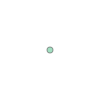

In [41]:
get_canonical_coords_google('807 BEACON CIR OAKDALE PA 15071')

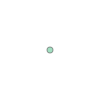

In [53]:
addr_to_coords('807 BEACON CIR OAKDALE PA 15071')

In [51]:
canonical_addr_map['807 BEACON CIR OAKDALE PA 15071']

{'canonical_in_census_db': False,
 'canonical_in_google_db': True,
 'census_block': u'420034580002086',
 'census_value': None,
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location_type": "ROOFTOP", "bounds": {"northeast": {"lat": 40.3930951, "lng": -80.1582646}, "southwest": {"lat": 40.3929375, "lng": -80.1584087}}, "viewport": {"northeast": {"lat": 40.39436528029149, "lng": -80.1569876697085}, "southwest": {"lat": 40.3916673197085, "lng": -80.1596856302915}}, "location": {"lat": 40.393051, "lng": -80.15833959999999}}, "address_components": [{"long_name": "807", "types": ["street_number"], "short_name": "807"}, {"long_name": "Beacon Circle", "types": ["route"], "short_name": "Beacon Cir"}, {"long_name": "Oakdale", "types": ["locality", "political"], "short_name": "Oakdale"}, {"long_name": "Collier Township", "types": ["administrative_area_level_3", "political"], "short_name": "Collier Township"}, {"long_name": "Allegheny County", "types": ["administrative_area_level_

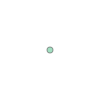

In [28]:
addr_to_coords('807 BEACON CIR OAKDALE PA 15071')

In [29]:
voter_map['109188400-02']

{'DOB': '4/15/1986',
 'addr_arr': [{'address': '807 BEACON CIR OAKDALE PA 15071',
   'census_block': u'420034580002086',
   'date': datetime.datetime(2018, 8, 24, 0, 0)}],
 'addresses': {'2018-08': '807 BEACON CIR OAKDALE PA 15071'},
 'reg_date': datetime.datetime(2018, 8, 24, 0, 0),
 'reg_info': {'2018-08': {'party': 'NF', 'status': 'A'}}}

In [52]:
# Reset
canonical_addr_map['807 BEACON CIR OAKDALE PA 15071']={'canonical_in_census_db': False,
 'canonical_in_google_db': False,
 'census_block': u'420034580002086',
 'census_value': None,
 'google_value': None}


# Process addrs_to_blocks_todo_set

In [64]:
# Construct GeoDataFrame from addrs_to_blocks and coords_to_blocks
todo_addrs_df = pd.DataFrame(addrs_to_blocks, columns=['address_raw'])
todo_geom_df = pd.Series(coords_to_blocks)

In [65]:
todo_gj = gpd.GeoDataFrame(todo_addrs_df, geometry=todo_geom_df,crs={'init': 'epsg:4326'})

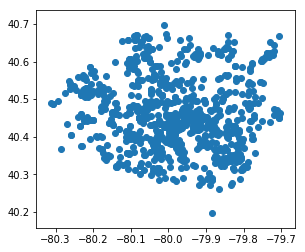

In [66]:
todo_gj.plot()

In [67]:
# Do spatial join to get census block for each address 
# Example from:
#    http://localhost:8820/notebooks/projects/demographics/Census-Planning-DB-2018.ipynb
# mob_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, mob_gj, how="inner", op='within')
todo_cb_gj = gpd.sjoin(todo_gj, ac_cb_gj, how="inner", op='within')

In [68]:
todo_cb_gj=todo_cb_gj.reset_index()

In [ ]:
todo_cb_gj

In [70]:
# Process all the newly processed census blocks into canonical_addr_map
process_addrs_to_cb_into_cam(todo_cb_gj)

Processing took 0:00:00.117206 for 964 addresses


In [229]:
list(todo_cb_gj.address_raw)

['205 BROOK ST MC DONALD PA 15057']

In [71]:
# Make a copy of addrs_to_blocks_todo_set to keep track of what addresses are left
# after we process the ones that came back with valid census blocks
failed_census_block_addrs = addrs_to_blocks_todo_set

# Remove all the elements that successfully generated census blocks
map(failed_census_block_addrs.remove, list(todo_cb_gj.address_raw))

# Update the vids in addrs_to_blocks_update_map={}
for addr in addrs_to_blocks_update_map:
    census_block = None
    # Check if this is a failed address
    if addr in failed_census_block_addrs:
        # Record 'census_block'=None in canonical_addr_map if not already recorded
        if(not 'census_block' in canonical_addr_map[addr]):
            canonical_addr_map[addr]['census_block']=None
    else:
        # Make sure addr is in canonical_addr_map
        if(not addr in canonical_addr_map or not 'census_block' in canonical_addr_map[addr]):
            print "ERROR: Trying to find census block for %s, but missing from canonical_addr_map" % (addr)
            continue
        # It is in canonical_addr_map, record the census block
        census_block = canonical_addr_map[addr]['census_block']
        
    # census_block should either be None or set to a valid value, record it in the relevant voter IDs.
    for vid in addrs_to_blocks_update_map[addr]:
        # Make sure vid is in voter_map
        if(not vid in voter_map):
            print "ERROR: Trying to update %s with census block %s, but missing from voter_map " % (vid, census_block)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "ERROR: Trying to update %s with census block %s, but 'addr_arr' missing from voter_map " % (vid, census_block)
            continue
        # Find the entry in addr_arr matching this address
        for i in range(0,len(voter_map[vid]['addr_arr'])):
            if(addr == voter_map[vid]['addr_arr'][i]['address']):
                # Matches! Update census block
                voter_map[vid]['addr_arr'][i]['census_block'] = census_block

In [233]:
'1741 BRODHEAD RD MOON TWP PA 15108' in addrs_to_blocks_update_map

True

In [72]:
failed_census_block_addrs

{'61 OLD JACKS RUN RD IRWIN PA 15642',
 '620 TULLAMORE TRAIL MARS PA 16046',
 '9441 NOBLESTOWN RD MC DONALD PA 15057'}

In [76]:
canonical_addr_map['620 TULLAMORE TRAIL MARS PA 16046']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': None,
 'census_value': '{"result": {"addressMatches": [], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "620 TULLAMORE TRAIL MARS PA 16046"}}}}',
 'google_value': '{"status": "OK", "results": [{"geometry": {"location_type": "APPROXIMATE", "bounds": {"northeast": {"lat": 40.702338, "lng": -80.00406799999999}, "southwest": {"lat": 40.6913781, "lng": -80.0243249}}, "viewport": {"northeast": {"lat": 40.702338, "lng": -80.00406799999999}, "southwest": {"lat": 40.6913781, "lng": -80.0243249}}, "location": {"lat": 40.6958996, "lng": -80.0117254}}, "formatted_address": "Mars, PA 16046, USA", "place_id": "ChIJ_VcUBgaGNIgRYWufKCeQGg0", "address_components": [{"long_name": "Mars", "types": ["locality", "political"], "short_name": "Mars"}, {"long_name": "Adams Township", "types"

In [79]:
coords = addr_to_coords('9441 NOBLESTOWN RD MC DONALD PA 15057')
print "%f %f" % (coords.y, coords.x)

40.366776 -80.284990


In [80]:
# Add failed_census_block_addrs to uncomputable_census_block_addrs_set
uncomputable_census_block_addrs_set = uncomputable_census_block_addrs_set.union(failed_census_block_addrs)
print "Added %d addrs to uncomputable_census_block_addrs_set, size now %d" % (len(failed_census_block_addrs), len(uncomputable_census_block_addrs_set))

Added 3 addrs to uncomputable_census_block_addrs_set, size now 271


In [81]:
# Reset TODO related variables to be empty
addrs_to_blocks_todo_set=set()
addrs_to_blocks=[]
coords_to_blocks=[]
addrs_to_blocks_update_map={}


In [196]:
# From ~/education/earthtime/voting/update_vids_in_addrs_to_blocks_update_map_out.txt
# These appear to be addresses that did not match to any of the census blocks
reprocess_addrs = ['14 BEECH ST AMBRIDGE PA 15003',
'245 ERMA ST RD1 MONONGAHELA PA 15063',
'915 INDIANA AVE GLASSPORT PA 15045',
'234 CENTER AVE CECIL PA 15321',
'896 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1036 OLD ORCHARD CT GIBSONIA PA 15044',
'1268 US ROUTE 30 CLINTON PA 15026',
'124 FINLEYVILLE R D 4 BOX FINLEYVILLE PA 15332',
'501 EASTVIEW DR IRWIN PA 15642',
'491 EASTVIEW DR IRWIN PA 15642',
'320 MILLERS-HILL RD RD2 BOX NEW KENSINGTON PA 15068',
'78 BEECH ST AMBRIDGE PA 15003',
'131 MAIN ST PO BOX RUSSELLTON PA 15076',
'277 STATE RTE 30 CLINTON PA 15026',
'1171 CAMBIER DR CRESCENT PA 15046',
'187 AIRPORT RD BELLE VERNON PA 15012',
'170 OLD JACKS RUN RD IRWIN PA 15642',
'106 DAVIS LN SEWICKLEY PA 15143',
'LOGANS FERRY RD NEW KENSINGTON PA 15068',
'405 PATRICKS PL MARS PA 16046',
'100 RIDGE RD RD1 MARS PA 16046',
'14 BEAVER ST AMBRIDGE PA 15003',
'2734 MILFORD DR BETHEL PARK PA 15102',
'961 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'205 BROOK ST MC DONALD PA 15057',
'101 PLEASANT RISE DR MCDONALD PA 15057',
'6 BEECH ST AMBRIDGE PA 15003',
'110 HIMALAYA RD MONROEVILLE PA 15146',
'337 COAL ST MCDONALD PA 15057',
'513 TUSCARORA RD MARS PA 16046',
'302 STATE RTE 8 BOX BAKERSTOWN PA 15007',
'162 RICHLAND MOBILE HOME PARK GIBSONIA PA 15044',
'FOX HILL BLACKBURN RD SEWICKLEY PA 15143',
'648 MILLERS RUN RD CECIL PA 15321',
'257 COLLINS AVE P O BOX CLAIRTON PA 15025',
'533 5TH ST TRAFFORD PA 15085',
'139 CHRISTY RD BOX TARENTUM PA 15084',
'STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1963 LINCOLN HWY NORTH VERSAILLES PA 15137',
'2100 SHORT ST FINLEYVILLE PA 15332',
'147 STATE RTE 30 CLINTON PA 15026',
'206 STATE RTE 51 RD4 BOX ELIZABETH PA 15037',
'500 BEAGLE CLUB RD MCDONALD PA 15057',
'1252 STATE RTE 30 CLINTON PA 15026',
'126 WOODLAWN AVE CECIL PA 15321',
'81 RIDGE RD MONONGAHELA PA 15063',
'224 RIDGE RD RD1 MARS PA 16046',
'22 FORBES RD TRAFFORD PA 15085',
'105 GRANT ST MCDONALD PA 15057',
'51 CHARLES ST CECIL PA 15321',
'4117 WINTERBURN AVE PITTSBURGH PA 15207',
'476 BEAGLE CLUB RD MC DONALD PA 15057',
'3780 FAIRVIEW DR MURRYSVILLE PA 15668',
'128 WOODLAWN AVE CECIL PA 15321',
'4 KRISTOFF LN MCDONALD PA 15057',
'145 RIDGE RD MONONGAHELA PA 15063',
'1385 STATE RTE 30 CLINTON PA 15026',
'979 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1248 US ROUTE 30 CLINTON PA 15026',
'4305 WINTERBURN AVE PITTSBURGH PA 15207',
'5066 IMPALA DR PITTSBURGH PA 15239',
'172 CANNON HILL RD SAXONBURG PA 16056',
'1285 STATE RTE 30 CLINTON PA 15026',
'404 PATRICKS PL MARS PA 16046',
'119 RIDGE RD MONONGAHELA PA 15063',
'8 BEECH ST AMBRIDGE PA 15003',
'3401 LOGANS FERRY RD MURRYSVILLE PA 15668',
'590 OLD JACKS RUN RD IRWIN PA 15642',
'1971 GREENSBURG RD NEW KENSINGTON PA 15068',
'678 PRINCETON BLVD PITTSBURGH PA 15221',
'1297 STATE RTE 30 CLINTON PA 15026',
'1281 STATE RTE 30 CLINTON PA 15026',
'4 BEECH ST AMBRIDGE PA 15003',
'114 RIDGE RD MONONGAHELA PA 15063',
'1282 STATE RTE 30 CLINTON PA 15026',
'131 RIDGE RD MONONGAHELA PA 15063',
'1368 STATE RTE 30 CLINTON PA 15026',
'2 CENTER AVE RD1 BOX MONONGAHELA PA 15063',
'138 HIGH ST MC DONALD PA 15057',
'1035 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'123 RIDGE RD MONONGAHELA PA 15063',
'218 MONONGAHELA R D MONONGAHELA PA 15063',
'2900 COULTERVILLE RD MCKEESPORT PA 15131',
'476 BEAGLE CLUB RD MCDONALD PA 15057',
'181 ROBINSON RUN RD RD6 MCDONALD PA 15057',
'242 BLYTHE RD BOX MCDONALD PA 15057',
'185 GAYDOS LN SEWICKLEY PA 15143',
'490 OLD JACKS RUN RD IRWIN PA 15642',
'864 HILL ST NEW KENSINGTON PA 15068',
'54 CHARLES ST CECIL PA 15321',
'106 HIMALAYA RD MONROEVILLE PA 15146',
'230 CENTER AVE CECIL PA 15321',
'MANOWN RD PO BOX MONONGAHELA PA 15063',
'2104 SHORT ST FINLEYVILLE PA 15332',
'527 5TH ST TRAFFORD PA 15085',
'1039 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'44 ROBINSON RUN RD MC DONALD PA 15057',
'347 CENTER AVE MCDONALD PA 15057',
'116 RIDGE RD MONONGAHELA PA 15063',
'715 SCHOOL ST MC KEES ROCKS PA 15136',
'188 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 WARRENDALE RD MARS PA 16046',
'339 COAL ST MCDONALD PA 15057',
'1005 CONOVER DR NEW KENSINGTON PA 15068',
'225 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'215 KIRKWOOD DR PITTSBURGH PA 15215',
'142 CHRISTY RD TARENTUM PA 15084',
'236 CENTER AVE CECIL PA 15321',
'135 RIDGE RD MONONGAHELA PA 15063',
'164 CANNON HILL RD SAXONBURG PA 16056',
'10 NOBLESTOWN RD OAKDALE PA 15071',
'1360 US ROUTE 30 CLINTON PA 15026',
'337 CENTER AVE MC DONALD PA 15057',
'116 GRANT ST MC DONALD PA 15057',
'134 CHRISTY RD BOX TARENTUM PA 15084',
'113 RIDGE RD MONONGAHELA PA 15063',
'122 WOODLAWN AVE CECIL PA 15321',
'1285 US ROUTE 30 CLINTON PA 15026',
'1927 DIXIE LN MONONGAHELA PA 15063',
'118 RIDGE RD MONONGAHELA PA 15063',
'2 KRISTOFF LN MC DONALD PA 15057',
'491 OLD JACKS RUN RD IRWIN PA 15642',
'110 GRANT ST MCDONALD PA 15057',
'4218 LOGANS FERRY RD MURRYSVILLE PA 15668',
'145 STATE RTE 8 BOX VALENCIA PA 16059',
'343 COAL ST MCDONALD PA 15057',
'65 RIDGE RD MONONGAHELA PA 15063',
'118 WOODLAWN AVE CECIL PA 15321',
'WARRENDALE AMBRIDGE RD BADEN PA 15005',
'102 MONTROSE AVE FREEPORT PA 16229',
'116 HIMALAYA RD MONROEVILLE PA 15146',
'330 DEER CREEK RD GIBSONIA PA 15044',
'814 WETTACH ST PITTSBURGH PA 15212',
'120 WOODLAWN AVE CECIL PA 15321',
'325 COAL ST MCDONALD PA 15057',
'500 BEAGLE CLUB RD MC DONALD PA 15057',
'115 GRANT ST MCDONALD PA 15057',
'178 AIRPORT RD BELLE VERNON PA 15012',
'219 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1132 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'67 ROBINSON RUN RD MC DONALD PA 15057',
'109 RIDGE RD MONONGAHELA PA 15063',
'144 CENTER AVE CECIL PA 15321',
'238 STATE RTE 51 FINLEYVILLE PA 15332',
'95 GLASGOW RD RD1 BOX VALENCIA PA 16059',
'1787 SILLVIEW DR PITTSBURGH PA 15243',
'1272 US ROUTE 30 CLINTON PA 15026',
'208 TECH RD PITTSBURGH PA 15205',
'327 COAL ST MC DONALD PA 15057',
'226 CENTER AVE CECIL PA 15321',
'1109 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'2821 BEECHWOOD BLVD PITTSBURGH PA 15217',
'WALKER RD RD MCDONALD PA 15057',
'60 CHARLES ST CECIL PA 15321',
'150 WILDFLOWER LN MARS PA 16046',
'36 BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'1370 STEWART RD MC DONALD PA 15057',
'184 ALDER ST RD3 BOX TARENTUM PA 15084',
'1270 STATE RTE 30 CLINTON PA 15026',
'404 MARBLE DR CRESCENT PA 15046',
'450 OLD JACKS RUN RD IRWIN PA 15642',
'71 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'236 STATE RTE 51 FINLEYVILLE PA 15332',
'196 WILMOT ST DUQUESNE PA 15110',
'126 RIDGE RD MONONGAHELA PA 15063',
'1081 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'298 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'16 BEAVER ST AMBRIDGE PA 15003',
'100 RIDGE RD MONONGAHELA PA 15063',
'1929 DIXIE LN MONONGAHELA PA 15063',
'1360 STEWART RD MCDONALD PA 15057',
'2020 SNOWDEN RD FINLEYVILLE PA 15332',
'BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'245 KRAMER RD SOUTH PARK PA 15129',
'335 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'3629 LOGANS FERRY RD MURRYSVILLE PA 15668',
'52 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'245 SPRING ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MC DONALD PA 15057',
'1469 STATE RTE 30 CLINTON PA 15026',
'BROADHEAD TR CT LOT CORAOPOLIS PA 15108',
'PARK RD CECIL PA 15321',
'400 OLD JACKS RUN RD IRWIN PA 15642',
'1282 US ROUTE 30 CLINTON PA 15026',
'1926 DIXIE LN MONONGAHELA PA 15063',
'1963 BLYTHEDALE RD BUENA VISTA PA 15018',
'27 MAIN ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MCDONALD PA 15057',
'351 STATE RTE 30 CLINTON PA 15026',
'43 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'403 PATRICKS PL MARS PA 16046',
'104 RIDGE RD MONONGAHELA PA 15063',
'204 CRESCENT GARDEN DR PITTSBURGH PA 15235',
'228 CENTER AVE CECIL PA 15321',
'67 STATE RTE 8 BOX VALENCIA PA 16059',
'2020 HOOKSTOWN GRADE RD CLINTON PA 15026',
'203 WARRENDALE RD MARS PA 16046',
'60 DODDS AVE VALENCIA PA 16059',
'4 KRISTOFF LN MC DONALD PA 15057',
'1557 STATE RTE 30 CLINTON PA 15026',
'421 OLD JACKS RUN RD IRWIN PA 15642',
'139 STATE RTE 906 RD ELIZABETH PA 15037',
'543 5TH ST TRAFFORD PA 15085',
'345 SUNSET DR BADEN PA 15005',
'7536 MELROSE ST PITTSBURGH PA 15218',
'114 HIMALAYA RD MONROEVILLE PA 15146',
'2955 COULTERVILLE RD MCKEESPORT PA 15131',
'24 BEECH ST AMBRIDGE PA 15003',
'1270 US ROUTE 30 CLINTON PA 15026',
'1281 US ROUTE 30 CLINTON PA 15026',
'500 CENTER AVE CECIL PA 15321',
'234 RIDGE RD RD1 MARS PA 16046',
'1360 STATE RTE 30 CLINTON PA 15026',
'1223 COLLINS AVE JEFFERSON HILLS PA 15025',
'204 WARRENDALE RD MARS PA 16046',
'451 OLD JACKS RUN RD IRWIN PA 15642',
'323 COAL ST MCDONALD PA 15057',
'51 DEER CREEK RD GIBSONIA PA 15044',
'551 5TH ST TRAFFORD PA 15085',
'392 MILLERS RUN RD MORGAN PA 15064',
'508 TUSCARORA RD MARS PA 16046',
'130 RIDGE RD MONONGAHELA PA 15063',
'53 RIDGE RD MONONGAHELA PA 15063',
'57 RIDGE RD VALENCIA PA 16059',
'112 HIMALAYA RD MONROEVILLE PA 15146',
'289 CHARLES ST CECIL PA 15321',
'330 CENTER AVE MCDONALD PA 15057',
'101 PLEASANT RISE DR MC DONALD PA 15057',
'1403 STATE RTE 30 CLINTON PA 15026',
'78 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'97 BOCKTOWN RD RD1 BOX CLINTON PA 15026',
'369 OLD JACKS RUN RD IRWIN PA 15642',
'67 ROBINSON RUN RD MCDONALD PA 15057',
'1213 COLLINS AVE JEFFERSON HILLS PA 15025',
'8 CLINTON BOCKTOWN RD CLINTON PA 15026',
'1477 STATE RTE 30 CLINTON PA 15026',
'481 EASTVIEW DR IRWIN PA 15642',
'101 HILL ST MC DONALD PA 15057',
'200 WARRENDALE RD MARS PA 16046',
'1283 STATE RTE 30 CLINTON PA 15026',
'440 OLD JACKS RUN RD IRWIN PA 15642',
'202 WARRENDALE RD MARS PA 16046',
'2 KRISTOFF LN MCDONALD PA 15057',
'101 HILL ST MCDONALD PA 15057',
'212 CRAWFORD CT MARS PA 16046',
'508 SCENIC RIDGE DR FINLEYVILLE PA 15332',
'715 SCHOOL ST MCKEES ROCKS PA 15136',
'330 CENTER AVE MC DONALD PA 15057',
'10 RIDGE RD RD1 MARS PA 16046',
'123 STATE RTE 30 CLINTON PA 15026',
'44 ROBINSON RUN RD MCDONALD PA 15057',
'2 BEECH ST AMBRIDGE PA 15003',
'114 GRANT ST MCDONALD PA 15057',
'337 CENTER AVE MCDONALD PA 15057',
'232 CENTER AVE CECIL PA 15321',
'1136 US ROUTE 30 CLINTON PA 15026',
'402 SOUTHPOINT CT MCDONALD PA 15057',
'7 2ND ST PITTSBURGH PA 15215',
'535 5TH ST TRAFFORD PA 15085',
'1268 STATE RTE 30 CLINTON PA 15026',
'240 BLYTHE RD BOX MCDONALD PA 15057',
'499 CENTER AVE CECIL PA 15321',
'10 BEECH ST AMBRIDGE PA 15003',
'273 BOCKTOWN RD PO BOX CRESCENT PA 15046',
'215 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 MURRYSVILLE RD NEW KENSINGTON PA 15068',
'CHRISTY COR NEW KENSINGTON PA 15068',
'101 RIDGE RD MONONGAHELA PA 15063',
'1280 US ROUTE 30 CLINTON PA 15026']


In [200]:
reprocess_vids = set()

In [208]:
for this_addr in reprocess_addrs:
    map(reprocess_vids.add,addrs_to_blocks_update_map[this_addr])

In [210]:
len(reprocess_vids)

474

In [212]:
voter_process_address_history_array(list(reprocess_vids),True)

Processing took 0:00:00.038317 for 474 addresses


# Test voter_process_address_history_array components

In [86]:
voter_map[voter_map.keys()[0]]={'DOB': '1/8/1944',
 'addresses': {'2009-07': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2017-11': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-03': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-08': '415 CHESTNUT ST SPRINGDALE PA 15144'},
 'reg_date': datetime.datetime(1993, 4, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'D', 'status': 'A'},
  '2017-11': {'party': 'D', 'status': 'A'},
  '2018-03': {'party': 'D', 'status': 'A'},
  '2018-08': {'party': 'D', 'status': 'A'}}}

In [119]:
voter_map[voter_map.keys()[3]]={'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [120]:
i=3
voter_map[voter_map.keys()[i]]

{'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [127]:
voter_process_address_history(voter_map.keys()[i], True)

[{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  'census_block': u'420035263012005',
  'date': datetime.datetime(1990, 10, 1, 0, 0)},
 {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  'date': datetime.datetime(2017, 11, 30, 0, 0)},
 {'address': '509 OCTOBER CT PLUM PA 15239',
  'census_block': None,
  'date': datetime.datetime(2018, 8, 14, 0, 0)}]

In [153]:
voter_map[voter_map.keys()[3]]

{'DOB': '8/29/1972',
 'addr_arr': [{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
   'census_block': u'420035263012005',
   'date': datetime.datetime(1990, 10, 1, 0, 0)},
  {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
   'census_block': u'420035263011014',
   'date': datetime.datetime(2017, 11, 30, 0, 0)},
  {'address': '509 OCTOBER CT PLUM PA 15239',
   'census_block': None,
   'date': datetime.datetime(2018, 8, 14, 0, 0)}],
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [129]:
addrs_to_blocks_todo_set

{'3014 SETTLERS CT MURRYSVILLE PA 15668'}

In [130]:
addrs_to_blocks

['3014 SETTLERS CT MURRYSVILLE PA 15668']

In [131]:
coords_to_blocks

In [132]:
addrs_to_blocks_update_map

{'3014 SETTLERS CT MURRYSVILLE PA 15668': {'002323758-02'}}

# Compute vote moved since last vote

In [402]:
# Keep track of which current voters are still voted_since_move==False
# with their most current address and still registered
# Returns true or false
def voter_moved_since_last_vote(vid):
    if (not vid in voter_map or not 'addr_arr' in voter_map[vid] or not 'vote_info' in voter_map[vid]):
        return (unknown_color, max_datetime)
    
    vrec = voter_map[vid]
     
    if(len(vrec['addr_arr'])<1):
        return(False)
    
    # Check if they moved away
    moved_ms = check_voter_moved_away(vid)
    if(moved_ms):
        #print"%s: False, moved away"%(vid)
        return(False)
    
    latest_addr_rec = vrec['addr_arr'][-1]

    # Get the start time for this address.
    addr_start_date = latest_addr_rec['date']

    # Get the next vote after addr_start_date
    next_vote_rec=get_next_vote_str_rec_after_date(vrec['vote_info'], addr_start_date)
    if(next_vote_rec):
        #print"%s: False, voted %s > %s"%(vid, next_vote_rec[1]['date'], addr_start_date)
        return(False)
    
    # No vote record more recent than the first known instance of the current addres.
    #print"%s: True, no vote after %s"%(vid, addr_start_date)
    return(True)

In [403]:
for vid in list(vdf_2018_10[0:10].index):
        mslv = voter_moved_since_last_vote(vid)
        if(mslv):
            print "%s" % (vid)

108927574-02
002184557-02


In [ ]:
voter_map['002184557-02']

In [399]:
vt = vdf_2018_10[0:10].copy()

In [400]:
vt['moved_since_voted'] = vt.index.map(voter_moved_since_last_vote)

108927574-02: True, no vote after 2018-08-14 00:00:00
103133442-02: False, voted 2011-11-08 00:00:00 > 2011-07-24 00:00:00
102892955-02: False, voted 2010-11-02 00:00:00 > 2010-09-28 00:00:00
020340986-02: False, voted 2016-11-08 00:00:00 > 2013-02-19 00:00:00
003007111-02: False, voted 1984-05-16 00:00:00 > 1984-03-01 00:00:00
020029602-02: False, voted 2003-11-06 00:00:00 > 2003-10-25 00:00:00
002171843-02: False, voted 1984-11-06 00:00:00 > 1974-10-01 00:00:00
002184557-02: True, no vote after 2017-11-30 00:00:00
107205165-02: False, voted 2016-11-08 00:00:00 > 2016-03-31 00:00:00
102729360-02: False, voted 2012-11-06 00:00:00 > 2010-03-09 00:00:00


In [404]:
vdf_2018_10['moved_since_voted'] = vdf_2018_10.index.map(voter_moved_since_last_vote)

In [406]:
vdf_2018_10_msv = vdf_2018_10[vdf_2018_10['moved_since_voted']].copy()

#### Get Polling Place info

In [424]:
pp_info={}

In [434]:
for i in range(0,len(pp_2018_11)):
    mwd = str(pp_2018_11['MWD2'].iloc[i])
    pp_info[mwd]={'muni_name':pp_2018_11['MuniName'].iloc[i],
                  'ward':pp_2018_11['Ward'].iloc[i],
                  'district':pp_2018_11['District'].iloc[i],
                  'loc_name':pp_2018_11['LocName'].iloc[i],
                  'address':'%s %s, PA %s'%(pp_2018_11['NewAddress'].iloc[i],
                                            pp_2018_11['City'].iloc[i],
                                            pp_2018_11['Zip'].iloc[i])
                 }
    

In [435]:
pp_info['1850905']

{'address': u'8351 PIERCE ST VERONA, PA 15147',
 'district': 5,
 'loc_name': u'HILLTOP COMM ALLIANCE CH.',
 'muni_name': u'PENN HILLS',
 'ward': 9}

In [436]:
# Manually add missing values
pp_info['1370700']={'muni_name':'ELIZABETH TP',
                  'ward':7,
                  'district':0,
                  'loc_name':'BLAINE HILL VOL FIRE CO',
                  'address':'409 OXFORD AVE ELIZABETH, PA 15037'}

In [437]:
pp_info['1450203']={'muni_name':'FRANKLIN PK',
                  'ward':2,
                  'district':3,
                  'loc_name':'ST JOHN NEUMANN',
                  'address':'2230 ROCHESTER ROAD PITTSBURGH, PA 15237'}

In [420]:
pp_2018_11[pp_2018_11.MWD2==1850905]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1099,777,778.0,185,9,5,HILLTOP COMM ALLIANCE CH.,None,8351,None,PIERCE,ST,None,VERONA,None,None,15147,0294J00075000000,None,35,3,1.380659e+06,422868.906355,14.0,43.0,32.0,None,PENN HILLS,8351 PIERCE STREET,1850905,1.380659e+06,422868.906355,1850905,8351 PIERCE ST,POINT (-79.86320909954804 40.47484364147486)


In [441]:
len(pp_2018_11)

1322

#### Group by precinct

In [442]:
msv_per_precinct = vdf_2018_10_msv.groupby(['Dist1'])
for precinct,group in msv_per_precinct:
    pp=pp_info[precinct]
    print "%4d %12s %02d %02d (%s)" % (len(group), pp['muni_name'], int(pp['ward']), int(pp['district']), precinct)

 476       ALEPPO 00 01 (1010001)
 364    ASPINWALL 00 01 (1020001)
 238    ASPINWALL 00 02 (1020002)
 303    ASPINWALL 00 03 (1020003)
 489       AVALON 01 00 (1030100)
 296       AVALON 02 01 (1030201)
 207       AVALON 02 02 (1030202)
 107       AVALON 03 01 (1030301)
 210       AVALON 03 02 (1030302)
 227       AVALON 03 03 (1030303)
 160   BALDWIN BR 00 01 (1040001)
 302   BALDWIN BR 00 02 (1040002)
 276   BALDWIN BR 00 03 (1040003)
 205   BALDWIN BR 00 04 (1040004)
 264   BALDWIN BR 00 05 (1040005)
 230   BALDWIN BR 00 06 (1040006)
 226   BALDWIN BR 00 07 (1040007)
 251   BALDWIN BR 00 08 (1040008)
 185   BALDWIN BR 00 09 (1040009)
 549   BALDWIN BR 00 10 (1040010)
 613   BALDWIN BR 00 11 (1040011)
 163   BALDWIN BR 00 12 (1040012)
 138   BALDWIN BR 00 13 (1040013)
 201   BALDWIN BR 00 14 (1040014)
 189   BALDWIN BR 00 15 (1040015)
 275   BALDWIN BR 00 16 (1040016)
 204   BALDWIN BR 00 17 (1040017)
 232   BALDWIN BR 00 18 (1040018)
 169   BALDWIN TP 00 01 (1050001)
 198   BALDWIN

 134   PITTSBURGH 14 38 (1881438)
 183   PITTSBURGH 14 39 (1881439)
 240   PITTSBURGH 14 40 (1881440)
  21   PITTSBURGH 14 41 (1881441)
 260   PITTSBURGH 15 01 (1881501)
 289   PITTSBURGH 15 02 (1881502)
 225   PITTSBURGH 15 03 (1881503)
 237   PITTSBURGH 15 04 (1881504)
 229   PITTSBURGH 15 05 (1881505)
 168   PITTSBURGH 15 06 (1881506)
 226   PITTSBURGH 15 07 (1881507)
 212   PITTSBURGH 15 08 (1881508)
  65   PITTSBURGH 15 09 (1881509)
 192   PITTSBURGH 15 10 (1881510)
 170   PITTSBURGH 15 11 (1881511)
 154   PITTSBURGH 15 12 (1881512)
 243   PITTSBURGH 15 13 (1881513)
 144   PITTSBURGH 15 14 (1881514)
 213   PITTSBURGH 15 15 (1881515)
 200   PITTSBURGH 15 16 (1881516)
   8   PITTSBURGH 15 17 (1881517)
 223   PITTSBURGH 15 18 (1881518)
 228   PITTSBURGH 15 19 (1881519)
 475   PITTSBURGH 16 01 (1881601)
 731   PITTSBURGH 16 02 (1881602)
 515   PITTSBURGH 16 03 (1881603)
 203   PITTSBURGH 16 04 (1881604)
 291   PITTSBURGH 16 05 (1881605)
 190   PITTSBURGH 16 06 (1881606)
 182   PITTSBU

In [440]:
len(msv_per_precinct)

1322

# Generate random points in census blocks

In [82]:
# From http://localhost:8820/notebooks/projects/demographics/Get%20random%20census%20block%20points%20from%20prototiles.ipynb
import numpy as np
numpy_record_type = [('x','<f4'), ('y','<f4'), ('blockIdx', '<i4'), ('subIdx', '<i4')]
all_pts = np.memmap('prototiles/master-sorted-by-block.bin', dtype=numpy_record_type)

def find_point_idx(block_idx):
    min_idx = 0
    max_idx = len(all_pts) - 1
    while min_idx <= max_idx:
        test_idx = int((min_idx + max_idx) / 2)
        if block_idx > all_pts[test_idx][2]:
            min_idx = test_idx + 1
        elif block_idx < all_pts[test_idx][2] or all_pts[test_idx][3] != 0:
            max_idx = test_idx - 1
        else:
            return test_idx
    return [min_idx, max_idx]

        
def block_points(block_idx):
    ret = []
    idx = find_point_idx(block_idx)
    assert all_pts[idx][2] == block_idx and all_pts[idx][3] == 0
    while idx < len(all_pts):
        if all_pts[idx][2] == block_idx:
            ret.append({'x':all_pts[idx][0], 'y':all_pts[idx][1]})
        else:
            break
        idx += 1
    return ret

In [83]:
import json
block_geoids_2010 = json.load(open('block_geoids_2010.json'))

geoid2idx = {}
for i in range(0, len(block_geoids_2010)):
    geoid2idx[block_geoids_2010[i]] = i+1

In [84]:
# For each census block, keep track of what voter each index has been assigned to
# Top level key is census block number, secondary key is 'next' for keeping track of the next index to be assigned,
# 'points' for the value returned by block_points, and voter ID: index for other entries
block_id_use_map={}

In [85]:
# Keep track of which census blocks overflowed the number of points
block_id_overflow_set=set()

In [86]:
def block_get_voter_coords(census_block, vid):
    if(not census_block in block_id_use_map):
        # Need to create an entry, set 'next' to 0, initialize points
        # First convert from GEOID10 to the index into the block_idx
        block_idx = geoid2idx[census_block]
        point_arr = block_points(block_idx)
        block_id_use_map[census_block]={'next':0, 'points':point_arr, 'numpoints':len(point_arr)}
    # We know census_block is in block_id_use_map (which we may have just added)
    # Check if this voter ID is already registered
    if(vid in block_id_use_map[census_block]):
        # Already assigned, just use the same index as before
        point_idx=block_id_use_map[census_block][vid]
    else:
        # Not yet assigned, take the next available 
        # and increment 'next'
        point_idx = block_id_use_map[census_block]['next']
        if(point_idx>block_id_use_map[census_block]['numpoints']-1):
            # Overflow
            if(not census_block in block_id_overflow_set):
                block_id_overflow_set.add(census_block)
                print "WARNING: overflow in census block %s" % (census_block)
            # For now, just start reassigning numbers back at 0
            point_idx=0
            block_id_use_map[census_block]['next']=0
        block_id_use_map[census_block]['next'] = point_idx + 1
        block_id_use_map[census_block][vid] = point_idx
        
    # Retrieve the webmercator point from the points array.
    # Convert it to lat lon and create a Point to return.
    # Note that WebMercatorToLonLat(x,y) returns [lon, lat]
    # the args to create a Point are also (lon, lat)
    point_xy = block_id_use_map[census_block]['points'][point_idx]
    ll_arr = WebMercatorToLonLat(point_xy['x'],point_xy['y'])
    return Point(ll_arr[0], ll_arr[1])

In [87]:
def voter_get_coords_for_addr_history(vid, force_update):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return
    vrec = voter_map[vid]
    if(not 'addr_arr' in vrec):
        print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
        return

    addr_arr = vrec['addr_arr']
    for j in range(0,len(addr_arr)):
        addr_rec = vrec['addr_arr'][j]
        if(not 'census_block' in addr_rec):
            print "WARNING %s: '%s' lacks 'census_block', skipping" % (vid, this_addr)
            continue
        # census_block might be None, in which case don't get coords
        if(addr_rec['census_block']==None):
            continue
        try:
            coords = block_get_voter_coords(addr_rec['census_block'], vid)
            #print "Assigning %r to %s[%d]='%s'"%(coords, vid,j,addr_rec['census_block'])
            #voter_map[vid]['addr_arr'][j]['latlon'] = coords
            addr_rec['latlon'] = coords
        except Exception as e:
            print "ERROR: Exception getting coords for %s[%d]='%s': %s"%(vid,j,addr_rec['census_block'],e)

def voter_get_coords_for_addr_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_get_coords_for_addr_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d in todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [ ]:
voter_get_coords_for_addr_history_array(all_vids, False)

In [353]:
len(block_id_overflow_set)

90

In [368]:
overflow_block_ids=list(block_id_overflow_set)
numpoints = map(lambda x: block_id_use_map[x]['numpoints'], overflow_block_ids)
numvoters = map(lambda x: len(block_id_use_map[x])-3, overflow_block_ids)

In [369]:
overflow_blocks_df=pd.DataFrame(zip(overflow_block_ids,numpoints,numvoters),columns=['GEOID10','numpoints','numvoters'])

In [373]:
overflow_blocks_df=pd.DataFrame(zip(numpoints,numvoters),columns=['numpoints','numvoters'],index=overflow_block_ids)

In [ ]:
overflow_blocks_df

In [375]:
overflow_blocks_df.to_csv('voters/overflow_blocks_df.csv')

## Debug census block dots

In [378]:
voter_map[all_vids[1]]

{'DOB': '9/29/1926',
 'addr_arr': [{'address': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
   'census_block': None,
   'date': datetime.datetime(1956, 1, 1, 0, 0)},
  {'address': '1094 FOX CHAPEL RD PITTSBURGH PA 15238',
   'census_block': u'420034220001019',
   'date': datetime.datetime(2018, 8, 14, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4babaa1e90>}],
 'addresses': {'2017-11': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-03': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-08': '1094 FOX CHAPEL RD PITTSBURGH PA 15238'},
 'reg_date': datetime.datetime(1956, 1, 1, 0, 0),
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [326]:
census_block = voter_map[all_vids[1]]['addr_arr'][1]['census_block']
census_block

u'420034220001019'

In [330]:
str(block_get_voter_coords(census_block, all_vids[1]))

'POINT (-79.86298799514771 40.53353520356066)'

In [345]:
len(block_id_use_map['420030201001005']['points'])

60

In [347]:
block_id_use_map['420030201001005']['next']

184

In [327]:
block_idx = geoid2idx[census_block]
block_idx

8118177

In [ ]:
block_points(block_idx)

# Write out dots files

In [244]:
c=Colormap([
    '#414141',
    '#ff0000',
    '#ffff00',
    '#00ff00'
])
type(c[255])

instance

In [245]:
isinstance(c[255], Color)

True

In [251]:
varr = c[255].array()
pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})

array([  0, 255,   0, 255], dtype=uint8)

In [252]:
exec_ipynb('colormaps.ipynb')

In [255]:
parse_color(c[255])

65280.0

In [44]:
def color_from_floats(r,g,b):
    return r + g * 256.0 + b * 256.0 * 256.0

def pack_color(color):
    return color['r'] + color['g'] * 256.0 + color['b'] * 256.0 * 256.0;

def parse_color(color):
    if(isinstance(color, Color)):
        return color.float()
        
    color = color.strip()
    c = color
    try:
        if c[0] == '#':
            c = c[1:]
        if len(c) == 3:
            return pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})
        if len(c) == 6:
            return pack_color({'r': int(c[0:2], 16),
                               'g': int(c[2:4], 16),
                               'b': int(c[4:6], 16)})
    except:
        pass
    raise InvalidUsage('Cannot parse color <code><b>%s</b></code> from spreadsheet.<br><br>Color must be in standard web form, <code><b>#RRGGBB</b></code>, where RR, GG, and BB are each two-digit hexadecimal numbers between 00 and FF.<br><br>See <a href="https://www.w3schools.com/colors/colors_picker.asp">HTML Color Picker</a>' % color)

def parse_colors(colors):
    packed = [parse_color(color) for color in colors]
    return numpy.array(packed, dtype = numpy.float32)

In [111]:
out_suffix="05_09_13_17_18_18_18"

## Party registration to color

In [43]:
max_datetime = dateparser.parse('12/31/3000')
two_years_from_now = datetime.datetime.now() + timedelta(days=365*2)

start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
#other_color = '#decc64'
other_color = '#505050'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

## Num moves to color

In [45]:
# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)
vol_colors = ['#a50026','#cd2827','#e75436','#f7804b','#fdad61','#fed788','#ffffbf','#b9e0ed','#8dc0db','#699fca','#4d7db9','#3e5aa7','#313695']
def num_moves_to_color(vid, color_date):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    
    color = unknown_color
    addr_index=None
    
    # Find the index of the first address with addr_end_date > color_date
    for a_i in range(0,len(vrec['addr_arr'])):
        addr_rec = vrec['addr_arr'][a_i]

        # Get the start time for this address.
        addr_start_date = vrec['addr_arr'][a_i]['date']

        # Find the end time for this address.
        # If this is the last address 
        # and the voter hasn't moved away, set end_date to max
        addr_end_date=max_datetime
        if(a_i<len(vrec['addr_arr'])-1):
            # There's another address after this one, set end_date
            # to the start of the next address
            addr_end_date = vrec['addr_arr'][a_i+1]['date']
        else:
            # Check if they moved away
            moved_ms = check_voter_moved_away(vid)
            if(moved_ms):
                addr_end_date = monthstr_to_date_map[moved_ms]
        if(addr_end_date>color_date):
            addr_index=a_i
            break
            
    if(not addr_index==None):
        # We have a valid value, get the color
    
        if (addr_index < 1):
            color = vol_colors[0]
        #elif (volume < 3):
        #    return parse_color(vol_colors[1]) 
        #elif (volume < 4):
        #    return parse_color(vol_colors[2]) 
        #elif (volume < 5):
        #    return parse_color(vol_colors[3]) 
        elif (addr_index < 2):
            color = vol_colors[4]
        #elif (volume < 20):
        #    return parse_color(vol_colors[5]) 
        #elif (addr_index < 3):
        #    color = vol_colors[6]
        elif (addr_index < 3):
            color = vol_colors[7] 
        #elif (addr_index < 5):
        #    return parse_color(vol_colors[8]) 
        elif (addr_index < 4):
            color = vol_colors[9]
        #elif (volume < 300):
        #    return parse_color(vol_colors[10]) 
        #elif (volume < 500):
        #    return parse_color(vol_colors[11]) 
        else:
            color = vol_colors[12]
        
    return(color,addr_end_date)

In [46]:
start_date=dateparser.parse('1990-12-01')
(color, next_start_date) = num_moves_to_color('002015745-02', start_date)
print "%s, %s" % (color, next_start_date)

start_date=dateparser.parse('2017-11-30')
num_moves_to_color('002015745-02', start_date)

#a50026, 2009-07-22 00:00:00


('#699fca', datetime.datetime(2018, 8, 14, 0, 0))

In [49]:
start_date=dateparser.parse('2018-08-14')
num_moves_to_color('002015745-02', start_date)

('#313695', datetime.datetime(3000, 12, 31, 0, 0))

## Moving recency

In [351]:
# Moving recency, voted since move =yes color map
mr_vy_cmap = Colormap(['#9e5df7','#9244ff','#4f14a0'])
# Moving recency, voted since move =no color map
mr_vn_cmap = Colormap(['#ffffff','#fcf883','#f7ef00'])
unknown_color = Color('#303030')

# Number of years since last move when we bottom out on the color map
mr_sat_yrs = 10

def mr_yrs_to_idx(years):
    # Saturate at mr_sat_yrs
    years=min(years, float(mr_sat_yrs))
    idx = int(float(years)*255.0/(float(mr_sat_yrs)))
    return(idx)

# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

def move_recency_to_color(vid, color_date):
    if (not vid in voter_map or not 'addr_arr' in voter_map[vid] or not 'vote_info' in voter_map[vid]):
        return (unknown_color, max_datetime)
    
    vrec = voter_map[vid]
    
    color = unknown_color
    addr_index=None
    
    # Find the index of the first address with addr_end_date > color_date
    for a_i in range(0,len(vrec['addr_arr'])):
        addr_rec = vrec['addr_arr'][a_i]

        # Get the start time for this address.
        addr_start_date = vrec['addr_arr'][a_i]['date']

        # Find the end time for this address.
        # If this is the last address 
        # and the voter hasn't moved away, set end_date to max
        addr_end_date=max_datetime
        if(a_i<len(vrec['addr_arr'])-1):
            # There's another address after this one, set end_date
            # to the start of the next address
            addr_end_date = vrec['addr_arr'][a_i+1]['date']
        else:
            # Check if they moved away
            moved_ms = check_voter_moved_away(vid)
            if(moved_ms):
                addr_end_date = monthstr_to_date_map[moved_ms]
        if(addr_end_date>color_date):
            addr_index=a_i
            break
            
    if(addr_index==None):
        # Don't have an address for this person yet, return unknown_color and max_datetype
        return(unknown_color, max_datetime)
    
    # We do have an address for this person starting at addr_start_date.
    # Check to see if this person has voted since moving there
    vote_info_map=voter_map[vid]['vote_info']
    voted_since_move=False
    
    next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, addr_start_date)
    next_vote_date=None
    if(next_vote_rec):
        next_vote_date = next_vote_rec[1]['date']
        if(next_vote_date<=color_date):
            voted_since_move=True
    
    # Calculate how long ago they moved
    timedelta_since_last_move = color_date-addr_start_date
    yrs_ago= float(timedelta_since_last_move.days)/365.0
       
    # Calculate the index for this color
    color_idx = mr_yrs_to_idx(yrs_ago)
    
    # Use the color map based on voted_since_move
    color = mr_vy_cmap[color_idx] if voted_since_move else mr_vn_cmap[color_idx]
    
    #print "%s: %s [%s] curr addr %s->%s [%d], vote_date=%s (%s), %f years since last move" % (color_date, color, voted_since_move,
    #                                                                                          addr_start_date, addr_end_date, addr_index, 
    #                                                                                          next_vote_date, next_vote_rec[0] if next_vote_rec else 'None',
    #                                                                                          yrs_ago)

    # Compute the end time for this color.  
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    next_date = min(addr_end_date if addr_end_date else max_datetime, 
                    next_vote_date if next_vote_date and next_vote_date>color_date and not voted_since_move else max_datetime)

    if(next_date < next_year):
        # Address/vote comes sooner than a year from now, use that
        return(color,next_date)
    elif(next_year>=two_years_from_now):
        # Next year is too far in the future. End now
        return(color,max_datetime)
    elif(yrs_ago<mr_sat_yrs):
        # The next move/voting event is more than a year away and 
        # we have not yet hit rock bottom.
        # Just use next_year as the return value[1]
        return(color,next_year)

    # We have hit rock bottom, return next_date    
    return(color,next_date)

    

In [375]:
test_vid = '104103802-02'
start_date=voter_map[test_vid]['reg_date']
(color, next_start_date) = move_recency_to_color(test_vid, start_date)
print "%s, %s" % (color, next_start_date)


#ffffffff, 2014-11-04 00:00:00


In [376]:
html_str = ["<table>"]
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = move_recency_to_color(test_vid, next_start_date)
    html_str.append("<tr><td>%")
    html_str.append(color._repr_html_())
    html_str.append("</td><td>")
    html_str.append("%s" % (next_start_date))                 
    html_str.append("</td></tr>")
    
html_str.append("</table>")
display(HTML(''.join(html_str)))

% #9c58f8ff,2015-11-04 00:00:00
% #9953faff,2016-11-03 00:00:00
% #974efcff,2017-11-03 00:00:00
% #9549fdff,2018-11-03 00:00:00
% #9244ffff,2019-11-03 00:00:00
% #863bedff,3000-12-31 00:00:00


In [340]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = move_recency_to_color(test_vid, next_start_date)
    print "%s, %s" % (color, next_start_date)
 

#fefee7ff, 1952-12-31 00:00:00
#fefccdff, 1953-12-31 00:00:00
#fdfbb5ff, 1954-12-31 00:00:00
#fdf99cff, 1955-12-31 00:00:00
#fcf883ff, 1956-12-30 00:00:00
#fbf669ff, 1957-12-30 00:00:00
#faf44fff, 1958-12-30 00:00:00
#f9f334ff, 1959-12-30 00:00:00
#f8f11bff, 1960-12-29 00:00:00
#f7ef00ff, 2004-11-02 00:00:00
#4f14a0ff, 2013-02-19 00:00:00
#303030, 3000-12-31 00:00:00


In [349]:
voter_map[test_vid]

{'DOB': '11/15/1983',
 'addr_arr': [{'address': '4319 GRANDVIEW DR GIBSONIA PA 15044',
   'census_block': u'420034080021000',
   'date': datetime.datetime(2013, 11, 30, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4d48b91410>}],
 'addresses': {'2017-11': '4319 GRANDVIEW DR GIBSONIA PA 15044',
  '2018-03': '4319 GRANDVIEW DR GIBSONIA PA 15044',
  '2018-08': '4319 GRANDVIEW DR GIBSONIA PA 15044',
  '2018-10': '4319 GRANDVIEW DR GIBSONIA PA 15044'},
 'reg_date': datetime.datetime(2013, 11, 30, 0, 0),
 'reg_info': {'2017-11': {'party': 'D', 'status': 'A'},
  '2018-03': {'party': 'D', 'status': 'A'},
  '2018-08': {'party': 'D', 'status': 'A'},
  '2018-10': {'party': 'D', 'status': 'A'}},
 'vote_info': {'GN_11_04_14': {'how': 'AP', 'party': 'D'},
  'GN_11_08_16': {'how': 'AB', 'party': 'D'},
  'PR_04_26_16': {'how': 'AP', 'party': 'D'},
  'PR_05_15_18': {'how': 'AP', 'party': 'D'},
  'PR_05_16_17': {'how': 'AP', 'party': 'D'}}}

In [374]:
html_str = ["<table>"]
for i in range(0,mr_sat_yrs):
    html_str.append("<tr><td>%d:"%i)
    html_str.append(mr_vy_cmap[mr_yrs_to_idx(i)]._repr_html_())
    html_str.append("</td><td>")
    html_str.append(mr_vn_cmap[mr_yrs_to_idx(i)]._repr_html_())                 
    html_str.append("</td></tr>")
    
html_str.append("</table>")
display(HTML(''.join(html_str)))
    

0: #9e5df7ff,#ffffffff
1: #9c58f9ff,#fefee7ff
2: #9953faff,#fefccdff
3: #974efcff,#fdfbb5ff
4: #9449fdff,#fdf99cff
5: #9244ffff,#fcf883ff
6: #853aecff,#fbf669ff
7: #7731d9ff,#faf44fff
8: #6a27c6ff,#f9f334ff
9: #5d1eb3ff,#f8f11bff


## Voting recency

In [240]:
vr_cmap = Colormap(['#ffffff','#00ff00','#008b00'])
# Number of years since last vote when we bottom out on the color map
vr_sat_yrs = 10

def vr_yrs_to_idx(years):
    # Saturate at vr_sat_yrs
    years=min(years, vr_sat_yrs)
    idx = int(float(years)*255.0/(float(vr_sat_yrs)))
    return(idx)
    
# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

# Keep track of the last color index and start date
# for each voter ID
# Key is vid, value is (last_vote_rec, next_vote_rec)
last_vr_color_state_map = {}

def voting_recency_vid_to_color(vid, color_date):
    if (not vid in voter_map or not 'vote_info' in voter_map[vid]):
        return(unknown_color, max_datetime)

    vrec = voter_map[vid]
    vote_info_map=voter_map[vid]['vote_info']
    
    last_vote_date=None
    next_vote_date=None

    # Check if we remember an earlier vote
    reset_color_state=True
    if(vid in last_vr_color_state_map):
        # We have a record, but it might be from a previous run
        (last_vote_rec,next_vote_rec) = last_vr_color_state_map[vid]
        if(last_vote_rec and last_vote_rec[1]['date']<=color_date):
            # It's from this run, keep it
            reset_color_state=False
            if(last_vote_rec):
                last_vote_date =last_vote_rec[1]['date']
            if(next_vote_rec):
                next_vote_date =next_vote_rec[1]['date']
            
    if(reset_color_state):
        # Start from scratch
        last_vote_rec=get_vote_str_rec_on_or_after_date(vote_info_map, color_date)
        if(last_vote_rec):
            last_vote_date =last_vote_rec[1]['date']
        next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
        if(next_vote_rec):
            next_vote_date =next_vote_rec[1]['date']
            
    # If last_vote_rec is None, that means we've run out of votes, return unknown_color and end of time
    if(not last_vote_rec):
        return(unknown_color, max_datetime)
    
    # If last_vote_date is still earlier than color_date, then the first vote hasn't happend yet.
    # Save last_vote_rec and next_vote_rec for next time and return unknown_color
    if(last_vote_date>color_date):
        #print "%s: last=%s (%s) hasn't started yet" % (color_date, last_vote_date, last_vote_rec[0])

        # Save state for next time
        last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)
        return(unknown_color, last_vote_date)
    
    # We have a last_vote_rec, see if we need to update to the next one
    while(next_vote_rec and next_vote_date<=color_date):
        last_vote_rec = next_vote_rec
        last_vote_date= next_vote_date
        next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
        if(next_vote_rec):
            next_vote_date =next_vote_rec[1]['date']
        else:
            next_vote_date=None
        
    # last_vote_rec is the last available at or before color_date
    timedelta_since_last_vote = color_date-last_vote_date
    years_since_last_vote=int(timedelta_since_last_vote.days/365)
    
    #print "%s: last=%s (%s), next=%s (%s), %d years since last vote" % (color_date, last_vote_date, last_vote_rec[0],next_vote_date, 
    #                                                                    next_vote_rec[0] if next_vote_rec else 'None',years_since_last_vote)
    
    # Save state for next time
    last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)
        
    # color_idx=0 (brightest) when < 1 year since last vote, darkest when >=vr_sat_yrs ago
    yrs_ago = min(years_since_last_vote, vr_sat_yrs)
    color_idx = vr_yrs_to_idx(yrs_ago)
    color=vr_cmap[color_idx]
    
    # Compute the end time for this color.  If next_vote_date and it's < 1 from color_date, then use that.
    # Otherwise use color_date+1 year
    next_date = next_vote_date
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    # If there is a next_date, and if it's sooner than a year from now, use it.
    # If there is no next_date and yrs_ago<vr_sat_yrs, then keep going with future 
    # years until yrs_ago==vr_sat_yrs or next_date >= two_years_from_now
    if(not next_date):
        # Check if they moved away
        moved_ms = check_voter_moved_away(vid)
        if(moved_ms):
            addr_end_date = monthstr_to_date_map[moved_ms]
            if(color_date>=addr_end_date):
                # Already painted the dot to the move date, return unknown_color to max_datetime
                return(unknown_color, max_datetime)
            elif(addr_end_date<next_year):
                # Moved away before the next year ends.  End at addr_end_date
                return(color, addr_end_date)
        # Didn't move away before next year
        if(yrs_ago<vr_sat_yrs and next_year<two_years_from_now):
            # Keep going with next_year
            next_date = next_year
        elif(not next_date or next_year>=two_years_from_now):
            # End now
            next_date = max_datetime
    elif(next_year<next_date and yrs_ago<vr_sat_yrs):
        # The next voting event is more than a year away and we have not yet hit rock bottom.
        # Just use next_year as the return value[1]
        next_date = next_year
    elif(yrs_ago == vr_sat_yrs):
        # We have hit rock bottom, return next_date
        pass
    elif(next_date<next_year and yrs_ago==0):
        # The next voting event is less than a year away and we're already at max engagement, 
        # keep checking until we find a gap > 1 yr long
        
        #print "Found a max engagement streak starting at %s" % (color_date)
        while(next_vote_rec and (next_vote_date-last_vote_date).days<365):
            last_vote_rec = next_vote_rec
            last_vote_date= next_vote_date
            next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
            if(next_vote_rec):
                next_vote_date =next_vote_rec[1]['date']
            else:
                next_vote_date=None
                #print "  Ended at %s (Last vote record)" % (last_vote_date)
                # Return last_vote_date + 1 year
                next_date = last_vote_date + timedelta(days=365)
                

        if(next_vote_date):
            #print "  Ended at %s (%d days -> %s)" % (last_vote_date, (next_vote_date-last_vote_date).days, 
            #                                         next_vote_date)
            # Return the date of the last chunk that had a gap <= 1 year apart
            next_date = last_vote_date


        # Save state for next time
        last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)

        
    #print "  color = %s (%d), next_date=%s"% (color, color_idx, next_date)
    return(color, next_date)

In [242]:
for i in range(0,vr_sat_yrs):
    display(vr_cmap[vr_yrs_to_idx(i)])

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

<__main__.Color instance at 0x7f49f7c643b0>

In [234]:
test_vid = '104103802-02'
start_date=dateparser.parse('2013-01-01 00:00:00')
(color, next_start_date) = voting_recency_vid_to_color(test_vid, start_date)
print "%s, %s" % (color, next_start_date)

last_vr_color_state_map['104103802-02']

#303030, 2014-11-04 00:00:00


(('GN_11_04_14',
  {'date': datetime.datetime(2014, 11, 4, 0, 0),
   'date_type': 'exact',
   'month_strs': {'2018-10'}}),
 ('PR_04_26_16',
  {'date': datetime.datetime(2016, 4, 26, 0, 0),
   'date_type': 'exact',
   'month_strs': {'2018-10'}}))

In [194]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = voting_recency_vid_to_color(test_vid, next_start_date)
    print "%s, %s" % (color, next_start_date)

#313695, 2015-11-04 00:00:00
#3e5aa7, 2016-04-26 00:00:00
#313695, 2019-05-15 00:00:00
#3e5aa7, 2020-05-14 00:00:00
#4d7db9, 3000-12-31 00:00:00


In [148]:
voter_map['001020958-02']

{'DOB': '08/22/1978',
 'addr_arr': [{'address': '126 SYCAMORE ST W PITTSBURGH PA 15211',
   'census_block': u'420031914001009',
   'date': datetime.datetime(1996, 8, 1, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4cf36502d0>}],
 'addresses': {'2009-07': '126 SYCAMORE ST W PITTSBURGH PA 15211'},
 'reg_date': datetime.datetime(1996, 8, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'D', 'status': 'A'}}}

In [125]:
check_voter_moved_away('001908830-02')

'2017-11'

## Registration recency

In [273]:
rr_cmap = Colormap(['#ffffff','#00ff00','#008b00'])
# Number of years since last vote when we bottom out on the color map
rr_sat_yrs = 10

def rr_yrs_to_idx(years):
    # Saturate at vr_sat_yrs
    years=min(years, rr_sat_yrs)
    idx = int(float(years)*255.0/(float(rr_sat_yrs)))
    return(idx)

# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)

# Keep track of the last color index and start date
# for each voter ID

def registration_recency_vid_to_color(vid, color_date):
    if (not vid in voter_map or not 'reg_date' in voter_map[vid]):
        return(unknown_color, max_datetime)

    vrec = voter_map[vid]
    reg_date = voter_map[vid]['reg_date']
   
    # If reg_date is still earlier than color_date, then hasn't registered yet.
    # Return unknown_color
    if(reg_date>color_date):
        #print "%s: last=%s (%s) hasn't started yet" % (color_date, last_vote_date, last_vote_rec[0])
        return(unknown_color, reg_date)
    
    # last_vote_rec is the last available at or before color_date
    timedelta_since_reg = color_date-reg_date
    years_since_reg=int(timedelta_since_reg.days/365)
    
    #print "%s: last=%s (%s), next=%s (%s), %d years since last vote" % (color_date, last_vote_date, last_vote_rec[0],next_vote_date, 
    #                                                                    next_vote_rec[0] if next_vote_rec else 'None',years_since_reg)
    
    # color_idx=0 (brightest) when < 1 year since registration, darkest when >=rr_sat_yrs ago
    yrs_ago = min(years_since_reg, rr_sat_yrs)
    color_idx = rr_yrs_to_idx(yrs_ago)
    color=vr_cmap[color_idx]
    
    # Compute the end time for this color.  
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    next_date = next_year
    
    # Check if they moved away
    moved_ms = check_voter_moved_away(vid)
    if(moved_ms):
        addr_end_date = monthstr_to_date_map[moved_ms]
        if(color_date>=addr_end_date):
            # Already painted the dot to the move date, return unknown_color to max_datetime
            return(unknown_color, max_datetime)
        elif(addr_end_date<next_year):
            # Moved away before the next year ends.  End at addr_end_date
            return(color, addr_end_date)

    # Didn't move away before next year
    if(yrs_ago<vr_sat_yrs and next_year<two_years_from_now):
        # Keep going with next_year
        next_date = next_year
    elif(next_year>=two_years_from_now):
        # End now
        next_date = max_datetime
    elif(yrs_ago<vr_sat_yrs):
        # The next voting event is more than a year away and we have not yet hit rock bottom.
        # Just use next_year as the return value[1]
        next_date = next_year
    elif(yrs_ago == rr_sat_yrs):
        # We have hit rock bottom, return max_datetime
        next_date = max_datetime
        
    #print "  color = %s (%d), next_date=%s"% (color, color_idx, next_date)
    return(color, next_date)

In [274]:
for i in range(0,rr_sat_yrs):
    display(rr_cmap[rr_yrs_to_idx(i)])

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

<__main__.Color instance at 0x7f4bc9e3b128>

In [275]:
test_vid = '002965853-02'
start_date=dateparser.parse('1983-01-01 00:00:00')
(color, next_start_date) = registration_recency_vid_to_color(test_vid, start_date)
print "%s, %s" % (color, next_start_date)

#ffffffff, 1984-01-01 00:00:00


In [276]:
while(next_start_date and next_start_date<max_datetime):
    (color, next_start_date) = registration_recency_vid_to_color(test_vid, next_start_date)
    print "%s, %s" % (color, next_start_date)

#cdffcdff, 1984-12-31 00:00:00
#99ff99ff, 1985-12-31 00:00:00
#67ff67ff, 1986-12-31 00:00:00
#33ff33ff, 1987-12-31 00:00:00
#01ff01ff, 1988-12-30 00:00:00
#00e800ff, 1989-12-30 00:00:00
#00d100ff, 1990-12-30 00:00:00
#00b900ff, 1991-12-30 00:00:00
#00a300ff, 1992-12-29 00:00:00
#008b00ff, 3000-12-31 00:00:00


# Output voter dots

In [51]:
# color_func(vid, color_date) returns (color, next_date)

def output_voter_reg_dots_f(vid_arr, color_func, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=10000
    dot_cnt=0
    
    for v_i in range(0,len(vid_arr)):
        try:
            vid = vid_arr[v_i]
            if(not vid in voter_map):
                continue
            vrec = voter_map[vid]

            if(not 'addr_arr' in vrec):
                continue

            # Get the month_str values in sorted order for this voter
            month_strs = sorted(vrec['reg_info'].keys())

            # Keep track of the date of the last datapoint. 
            # Initialize last_date to be the registration date for this voter

            last_date = vrec['reg_date']
            last_color=0


            # Keep track of the index of the next month_str
            next_month_str_i=0

            # Iterate over the addresses in addr_arr
            for a_i in range(0,len(vrec['addr_arr'])):
                addr_rec = vrec['addr_arr'][a_i]
                # If addr_rec is not plottable, skip it
                if(not 'latlon' in addr_rec):
                    continue

                # We have lat/lon for this address, continue
                centroid = addr_rec['latlon']
                if(not centroid):
                    continue

                # Get the start time for this address.
                addr_start_date = vrec['addr_arr'][a_i]['date']

                # Find the end time for this address.
                # If this is the last address 
                # and the voter hasn't moved away, set end_date to max
                addr_end_date=max_datetime
                if(a_i<len(vrec['addr_arr'])-1):
                    # There's another address after this one, set end_date
                    # to the start of the next address
                    addr_end_date = vrec['addr_arr'][a_i+1]['date']
                else:
                    # Check if they moved away
                    moved_ms = check_voter_moved_away(vid)
                    if(moved_ms):
                        addr_end_date = monthstr_to_date_map[moved_ms]
                        if((v_i%chunk_size)==0):
                            print "%s moved away by %s (%s)" % (vid, moved_ms,addr_end_date)

                if((v_i%chunk_size)==0):
                    print "%s[%d]: %s - %s [%s]" % (vid, a_i, addr_start_date, addr_end_date, last_date)

                # Call color_func and output dots until the date returned by color_func goes past the end of this address
                while(last_date<=addr_end_date):                    
                    did_output_dot=False

                    # Get color for this next chunk of time
                    (color, next_start_date) = color_func(vid, last_date)
                    
                    # Get range of dates for this color
                    startdate_epoch = GetEpoch(last_date)
                    enddate_epoch = GetEpoch(next_start_date)
                    if(color != None):
                        points += PointToPixelXY(centroid)     
                        points.append(parse_color(color))
                        points.append(float(startdate_epoch))
                        points.append(float(enddate_epoch))
                        if((v_i%chunk_size)==0):
                            print "  %s[%s]: %s - %s = %s" % (vid, a_i, last_date, next_start_date, color)
                    else:
                        print "Color of %s is None"

                    # Set last_date and last_color for next loop
                    last_date = next_start_date
                    last_color= color
                    did_output_dot=True
                    dot_cnt=dot_cnt+1
                    # Special case when next_start_date==addr_end_date
                    # to break out of the loop 
                    if(next_start_date>=addr_end_date):
                        break
                    # End of inner color_func loop
                # End of middle address_loop
            # End of try block at level of vid
        except:
            print "Unexpected error processing [%d] %s:" % (v_i, vid), sys.exc_info()[0]
            raise

        # Handle periodic debug message
        if((v_i%chunk_size)==0 and v_i>0):
            print "%d-%d: processing %r, %s time elapsed" %(v_i-(chunk_size-1), v_i, vid, arrow.now()-chunk_start_time)
            chunk_start_time=arrow.now()
                
    array.array('f', points).tofile(open(('voting/voter_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), dot_cnt)
    

#### 15213

In [53]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [54]:
output_voter_reg_dots_f(vids_15213[0:1000], num_moves_to_color, "num_moves_05_09_13_17_18_18_18_15213_g8")

102892955-02[0]: 2010-09-28 00:00:00 - 3000-12-31 00:00:00 [2010-09-28 00:00:00]
  102892955-02[0]: 2010-09-28 00:00:00 - 3000-12-31 00:00:00 = #a50026
Processing took 0:00:00.099407 for 1340 dots


In [ ]:
output_voter_reg_dots_f(vids_15213, move_recency_to_color, "move_recency_05_09_13_17_18_18_18_15213_g7")

In [ ]:
output_voter_reg_dots_f(vids_15213, voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_15213_g1")

In [ ]:
output_voter_reg_dots_b(vids_15213, "1810_15213_c")

### All independents

In [283]:
vdf_all_inds_2018_10 = vdf_2018_10[(~((vdf_2018_10['Political_Party']=='D')|(vdf_2018_10['Political_Party']=='R')))]

In [284]:
len(vdf_all_inds_2018_10)

132445

In [ ]:
output_voter_reg_dots_f(list(vdf_all_inds_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_all_inds_g5")

In [ ]:
output_voter_reg_dots_f(list(vdf_all_inds_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_all_inds_g6")

#### Active independents

In [202]:
vdf_active_inds_2018_10 = vdf_2018_10[(~((vdf_2018_10['Political_Party']=='D')|(vdf_2018_10['Political_Party']=='R')))&(vdf_2018_10['Voter_Status']=='A')]

In [203]:
len(vdf_active_inds_2018_10)

112817

In [ ]:
output_voter_reg_dots_f(list(vdf_active_inds_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_a_inds_g5")

In [ ]:
output_voter_reg_dots_f(list(vdf_active_inds_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_a_inds_g5")

#### All Republicans

In [267]:
vdf_all_reps_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='R')]

In [268]:
len(vdf_active_reps_2018_10)

240439

In [ ]:
output_voter_reg_dots_f(list(vdf_all_reps_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_all_reps_g6")

In [ ]:
output_voter_reg_dots_f(list(vdf_all_reps_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_all_reps_g6")

#### Active Republicans

In [200]:
vdf_active_reps_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='R')&(vdf_2018_10['Voter_Status']=='A')]

In [201]:
len(vdf_active_reps_2018_10)

240439

In [ ]:
output_voter_reg_dots_f(list(vdf_active_reps_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_a_reps_g4")

In [ ]:
output_voter_reg_dots_f(list(vdf_active_reps_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_a_reps_g4")

#### All Democrats

In [262]:
vdf_all_dems_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='D')]

In [263]:
len(vdf_all_dems_2018_10)

546626

In [ ]:
output_voter_reg_dots_f(list(vdf_all_dems_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_all_dems_g6")

In [ ]:
output_voter_reg_dots_f(list(vdf_all_dems_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_all_dems_g6")

#### Active Democrats

In [197]:
vdf_active_dems_2018_10 = vdf_2018_10[(vdf_2018_10['Political_Party']=='D')&(vdf_2018_10['Voter_Status']=='A')]

In [199]:
len(vdf_active_dems_2018_10)

489802

In [ ]:
output_voter_reg_dots_f(list(vdf_active_dems_2018_10.index), registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_a_dems_g3")

In [ ]:
output_voter_reg_dots_f(list(vdf_active_dems_2018_10.index), voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_a_dems_g3")

#### Whole county

In [57]:
all_vids=sorted(voter_map.keys())

In [58]:
len(all_vids)

1379040

In [ ]:
output_voter_reg_dots_f(all_vids, move_recency_to_color, "move_recency_05_09_13_17_18_18_18_g7")

In [ ]:
output_voter_reg_dots_f(all_vids, registration_recency_vid_to_color, "reg_recency_05_09_13_17_18_18_18_g6")

In [ ]:
output_voter_reg_dots_f(all_vids, voting_recency_vid_to_color, "vote_recency_05_09_13_17_18_18_18_g2")

In [ ]:
# Output all the voter dots for Allegheny County
# 17_18_18_18_c is all census_block points with independents in yellow
# 17_18_18_18_d is all census_block points with independents in dark grey
# 09_17_18_18_18_e is all census_block points with independents in dark grey and moved away checking
# num_moves_05_09_13_17_18_18_18_15213_g8 has additional years (05 and 13)
output_voter_reg_dots_f(all_vids, num_moves_to_color, "num_moves_05_09_13_17_18_18_18_15213_g8")

In [ ]:
# Output all the voter dots for Allegheny County
output_voter_reg_dots(all_vids, "17_18_18_b")

# Archive

In [194]:
failed_vids = []
for i in range(0,len(all_vids)):
    try:
        vid = all_vids[i]
        vrec = voter_map[vid]
        month_strs = sorted(vrec['reg_info'].keys())
        last_date = dateparser.parse(vrec['reg_date'])
    except Exception as e:
        print "%d: %s failed: %s\n\t%r" % (i,vid,e,vrec)
        failed_vids.append(i)

352013: 002748431-02 failed: Input type must be str or unicode
	{'DOB': '2/22/1943', 'reg_date': nan, 'addresses': {'2018-08': '3080 FELIX DR SOUTH PARK PA 15129', '2018-03': '3080 FELIX DR SOUTH PARK PA 15129', '2017-11': '3080 FELIX DR SOUTH PARK PA 15129'}, 'reg_info': {'2018-08': {'status': 'A', 'party': 'D'}, '2018-03': {'status': 'A', 'party': 'D'}, '2017-11': {'status': 'A', 'party': 'D'}}}


In [195]:
# Manually fixup Robert Felix to not have a nan reg_date
voter_map['002748431-02']['reg_date']="09/01/1944"

In [199]:
# Convert all the vrec['reg_date'] to be parsed dates: This only had to be done once!
#for vid in voter_map:
#    voter_map[vid]['reg_date'] = dateparser.parse(voter_map[vid]['reg_date'])

In [453]:
len(voter_map)

1217523

In [409]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [410]:
len(vids_15213)

28484

In [ ]:
output_voter_reg_dots(vids_15213, "1808_15213_b")

In [104]:
voter_map['102892955-02']['addresses']['2018-08']

'3990 A 5TH AVE PITT TOWERS PITTSBURGH PA 15213'

In [ ]:
vdf_2018_08.loc['002021371-02']

In [110]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

KeyError: '3725 SUTHERLAND DR PITTSBURGH PA 15213'

In [105]:
get_canonical_coords(voter_map['102892955-02']['addresses']['2018-08'])

In [106]:
get_canonical_coords_google(voter_map['102892955-02']['addresses']['2018-08'])

In [83]:
vid_to_coords('021189057-02','2018-08')

# Archive

In [ ]:
# This version predates addition of addr_arr and census_block IDs to voter map
start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    

# Lookup registration info

In [78]:
vdf_2018_10[(vdf_2018_10.Last_Name =='AUMAN')&(vdf_2018_10.First_Name.str.contains('AUDREY'))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                               AUMAN
First_Name                                             AUDREY
Date_Of_Birth                                      10/22/1955
address_raw             110 FREMONT AVE N PITTSBURGH PA 15202
Date_Registered                                      4/1/1983
StatusChangeDate                            1/20/2017 11:7:26
PollingPlaceDescript               FAIRVIEW VOLUNTEER FIRE CO
PollPlaceAdd                                 44 E FOREST AVE 
PollPlaceCSZ                                       ROSS, PA  
Last_Date_Voted                                     5/17/2011
Dist1                                                 1960603
Name: 002301600-02, dtype: object

In [67]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('GREEN'))&(vdf_2018_10.First_Name.str.contains('^ALV',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']]

,Last_Name,First_Name,Date_Of_Birth,address_raw,Date_Registered,StatusChangeDate,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1
ID_Number,,,,,,,,,,,
002946955-02,GREENE,ALVIN,12/21/1958,3158 GRIFFITHS ST PITTSBURGH PA 15213,1/1/2000,1/1/2000 0:0:0,ST REGIS CHURCH HALL,3250 PARKVIEW AVE,"PITTSBURGH, PA 15213",11/8/2016,1880417


In [70]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('GREEN'))&(vdf_2018_10.First_Name.str.contains('^ALV',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                              GREENE
First_Name                                              ALVIN
Date_Of_Birth                                      12/21/1958
address_raw             3158 GRIFFITHS ST PITTSBURGH PA 15213
Date_Registered                                      1/1/2000
StatusChangeDate                               1/1/2000 0:0:0
PollingPlaceDescript                     ST REGIS CHURCH HALL
PollPlaceAdd                               3250 PARKVIEW AVE 
PollPlaceCSZ                            PITTSBURGH, PA  15213
Last_Date_Voted                                     11/8/2016
Dist1                                                 1880417
Name: 002946955-02, dtype: object

In [71]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('GREEN'))&(vdf_2018_10.First_Name.str.contains('^KW',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                          GREENE
First_Name                                       KWEILYNN
Date_Of_Birth                                    5/5/1982
address_raw             703 LENOX AVE PITTSBURGH PA 15221
Date_Registered                                  7/1/2002
StatusChangeDate                           7/1/2002 0:0:0
PollingPlaceDescript                  FOREST HILLS V.F.D.
PollPlaceAdd                           2067 ARDMORE BLVD 
PollPlaceCSZ                        PITTSBURGH, PA  15221
Last_Date_Voted                                 5/15/2018
Dist1                                             1420007
Name: 002722638-02, dtype: object

In [73]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('NZONGOLA'))&(vdf_2018_10.First_Name.str.contains('^[KP]',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                      NZONGOLA
First_Name                                        KELLY
Date_Of_Birth                                 6/25/1984
address_raw             612 DAVIDSON DR VERONA PA 15147
Date_Registered                                4/1/2002
StatusChangeDate                       7/9/2013 12:7:51
PollingPlaceDescript      ST GERARD MAJELLA CHURCH HALL
PollPlaceAdd                               121 DAWN DR 
PollPlaceCSZ            PENN HILLS               , PA  
Last_Date_Voted                               5/16/2017
Dist1                                           1850801
Name: 002839529-02, dtype: object

In [76]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('GREENE'))&(vdf_2018_10.First_Name.str.contains('^EV',regex=True))&(vdf_2018_10.Zip_Code.str.contains('15207',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                            GREENE
First_Name                                           EVELYN
Date_Of_Birth                                    12/15/1930
address_raw             111 TECUMSEH ST PITTSBURGH PA 15207
Date_Registered                                    8/1/1991
StatusChangeDate                            10/7/2008 6:0:2
PollingPlaceDescript                     ENGINE COMPANY #13
PollPlaceAdd                               200 FLOWERS AVE 
PollPlaceCSZ                          PITTSBURGH, PA  15207
Last_Date_Voted                                         NaN
Dist1                                               1881513
Name: 001974553-02, dtype: object

In [81]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('GREENE'))&(vdf_2018_10.First_Name.str.contains('^ASH',regex=True))&(vdf_2018_10.Zip_Code.str.contains('15147',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                           GREENE
First_Name                                          ASHLEY
Date_Of_Birth                                   10/21/1987
address_raw             1644 VISTA VIEW DR VERONA PA 15147
Date_Registered                                  8/18/2005
StatusChangeDate                          10/15/2005 8:5:8
PollingPlaceDescript       ROSEDALE UN METH CH SOCIAL HALL
PollPlaceAdd                                  5501 3RD ST 
PollPlaceCSZ                              PENN HILLS, PA  
Last_Date_Voted                                  5/21/2013
Dist1                                              1850901
Name: 020579394-02, dtype: object

In [84]:
vdf_2018_10[(vdf_2018_10.First_Name.fillna('').str.contains('CHALD',regex=True))]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
## vdf_2018_10[(vdf_2018_10.Last_Name.fillna('').str.contains('BAKOUBOULA'))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

In [89]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('ADAMS'))&(vdf_2018_10.First_Name.str.contains('^MUMINA',regex=True))][['Last_Name','First_Name','Date_Of_Birth','address_raw','Date_Registered','StatusChangeDate','PollingPlaceDescript','PollPlaceAdd','PollPlaceCSZ','Last_Date_Voted','Dist1']].iloc[0]

Last_Name                                           ADAMS
First_Name                                         MUMINA
Date_Of_Birth                                   3/24/1975
address_raw             7056 KELLY ST PITTSBURGH PA 15208
Date_Registered                                  2/1/1994
StatusChangeDate                           2/1/1994 0:0:0
PollingPlaceDescript              CARNEGIE LIBRARY OF PGH
PollPlaceAdd                           7101 HAMILTON AVE 
PollPlaceCSZ                        PITTSBURGH, PA  15208
Last_Date_Voted                                 5/15/2018
Dist1                                             1881301
Name: 002337007-02, dtype: object